In [9]:
import geopandas as gpd
import rasterio
from shapely.geometry import Point
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyproj

# 读取矢量数据
# 读取矢量数据

river_gdf = gpd.read_file('../data/最新赣江河流.shp')
candidate_points_gdf = gpd.read_file('../data/含有保留点的总候选点.shp')

# 读取栅格数据
human_activity_raster_path = '../data/赣江沿岸五公里的人类足迹.tif'


human_activity_raster = rasterio.open(human_activity_raster_path)

# 打印数据的坐标系
print("河流数据的坐标系:", river_gdf.crs)
print("栅格数据的坐标系:", human_activity_raster.crs)
print("候选点数据的坐标系:", candidate_points_gdf.crs)

河流数据的坐标系: EPSG:4326
栅格数据的坐标系: EPSG:4326
候选点数据的坐标系: EPSG:4326


In [10]:
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.features import geometry_mask
import numpy as np
import pyproj
from rasterio.features import geometry_mask
class Individual:
    def __init__(self, chromosome):
        """
        初始化个体。
        
        参数：
        chromosome - 一个表示候选监测点选择状态的二进制数组。
        """
        self.chromosome = chromosome
        self.fitness = 0


In [11]:
import numpy as np
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import unary_union

class Population:
    def __init__(self, pop_size, num_candidates, num_selected_points, fixed_indices):
            """
            初始化种群。
            
            参数：
            pop_size - 种群大小，即种群中个体的数量。
            num_candidates - 候选监测点的数量，即个体染色体的长度。
            num_selected_points - 每个个体中选取的监测点数量。
            # fixed_indices - 一个列表，包含需要固定的监测点的索引。
            """
            self.pop_size = pop_size
            self.num_candidates = num_candidates
            self.num_selected_points = num_selected_points
            self.fixed_indices = fixed_indices
            self.individuals = [self.create_individual() for _ in range(pop_size)]

    def create_individual(self):
            """
            创建一个随机个体，确保个体中有指定数量的监测点被选中。
            
            返回：
            Individual - 新创建的个体。
            """
            # 初始化一个全零的染色体数组，长度为候选监测点的数量
            chromosome = np.zeros(self.num_candidates, dtype=int)
            # print(f"初始化的染色体: {chromosome}")
            
            # 注释掉固定的保留点设置为1
            chromosome[self.fixed_indices] = 1
            # print(f"设置固定保留点后的染色体 (固定索引: {self.fixed_indices}): {chromosome}")

            # 计算剩余需要选择的点的数量
            remaining_points = self.num_selected_points - len(self.fixed_indices)
            # print(f"剩余需要选择的点数量: {remaining_points}")
            # 检查剩余点数是否为负值，抛出异常
            if remaining_points < 0:
                raise ValueError("选择的点数量不能少于固定点的数量。")

            if remaining_points > 0:
                # 随机选择其余的点，排除已经固定的点
                available_indices = np.setdiff1d(np.arange(self.num_candidates), self.fixed_indices)
                # print(f"可供选择的索引: {available_indices}")

                selected_indices = np.random.choice(available_indices, remaining_points, replace=False)
                # print(f"随机选择的索引: {selected_indices}")

                chromosome[selected_indices] = 1
                # print(f"随机选择后的染色体: {chromosome}")
            
            # 返回一个新的 Individual 对象，使用生成的染色体数组初始化
            # print(f"最终染色体: {chromosome}")
            return Individual(chromosome)

    def evaluate_population(self, candidate_points_gdf, buffer_gdf, human_activity_raster):
        """
        评估种群中所有个体的适应度。
        
        参数：
        candidate_points_gdf - 包含候选点的 GeoDataFrame。
        buffer_gdf - 包含缓冲区几何的 GeoDataFrame。
        human_activity_raster - 人类活动强度的栅格数据。
        """
        for individual in self.individuals:
            # 获取该个体中选定的候选点索引（即该个体染色体中为1的基因对应的索引）
            selected_fids = [fid for fid, gene in zip(candidate_points_gdf['point_id'], individual.chromosome) if gene == 1]

            if len(selected_fids) == 0:
                # 如果没有选择任何点，则适应度为0
                individual.fitness = 0
                continue

            # 计算该个体的合并缓冲区的人类活动强度
            combined_intensity = self.calculate_intensity_for_merged_buffers(selected_fids, buffer_gdf, human_activity_raster)

            # 将合并强度作为该个体的适应度
            individual.fitness = combined_intensity
            
    def calculate_intensity_for_merged_buffers(self, selected_fids, buffer_gdf, raster):
            """
            计算选定候选点的合并缓冲区的人类活动强度。
            
            参数：
            selected_fids - 选定的候选点 FID 列表。
            buffer_gdf - 包含缓冲区几何的 GeoDataFrame。
            raster - 人类活动强度的栅格数据。
            
            返回：
            total_intensity - 合并缓冲区内的人类活动强度总值。
            """
            def calculate_intensity_for_buffer(buffer_geom, raster):
                """
                计算给定几何形状内的覆盖人类活动强度栅格值。
                
                参数：
                buffer_geom - 几何形状，用于计算的缓冲区或重叠区域。
                raster - 人类活动强度的栅格数据。
                
                返回：
                total_value - 几何形状内的总强度值。
                """
                # 1. 获取栅格的仿射变换信息（transform）和 NoData 值
                transform = raster.transform
                nodata_value = raster.nodata

                # 2. 创建掩膜，遮罩掉缓冲区外的像素，仅保留缓冲区内的像素
                try:
                    buffered_raster = geometry_mask([buffer_geom], transform=transform, invert=True, out_shape=(raster.height, raster.width))
                except ValueError as e:
                    print(f"几何对象无效或为空: {e}")
                    return 0

                # 3. 读取栅格数据（假设是单波段，读取第一波段数据）
                raster_data = raster.read(1)

                # 4. 应用掩膜，将缓冲区外的像素设置为 NaN，仅保留缓冲区内的像素
                masked_data = np.where(buffered_raster, raster_data, np.nan)

                # 5. 过滤掉 NoData 像素
                valid_raster_values = masked_data[masked_data != nodata_value]

                # 6. 如果没有有效的栅格值（即缓冲区内全为 NoData），返回 0
                if valid_raster_values.size == 0:
                    return 0

                # 7. 计算缓冲区内的总强度值
                total_value = np.nansum(valid_raster_values)

                return total_value

            # 1. 获取所有选定候选点的缓冲区几何
            selected_geometries = buffer_gdf.loc[buffer_gdf['所属点'].isin(selected_fids), 'geometry'].tolist()

            # 检查是否有有效的几何对象
            if len(selected_geometries) == 0:
                print("未找到有效的几何对象。")
                return 0

            # 2. 合并这些几何对象为一个单一几何对象
            try:
                merged_geometry = unary_union(selected_geometries)

                # 检查合并后的几何对象是否为空或无效
                if merged_geometry.is_empty:
                    print("合并后的几何对象为空。")
                    return 0

            except Exception as e:
                print(f"几何合并失败: {e}")
                return 0

            # 3. 使用合并后的几何对象计算人类活动强度
            total_intensity = calculate_intensity_for_buffer(merged_geometry, raster)
            
            return total_intensity



    def get_fittest_individual(self):
        """
        获取种群中适应度最高的个体。
        
        返回：
        Individual - 适应度最高的个体。
        """
        return max(self.individuals, key=lambda ind: ind.fitness)



In [12]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt


class GeneticAlgorithm:
    def __init__(self, pop_size, num_candidates, crossover_rate, mutation_rate, max_generations, num_selected_points, fixed_indices,k):
        """
        初始化遗传算法参数。
        
        参数：
        pop_size - 种群大小，即种群中个体的数量。
        num_candidates - 候选监测点的数量，即个体染色体的长度。
        crossover_rate - 交叉概率。
        mutation_rate - 变异概率。
        max_generations - 最大迭代次数。
        num_selected_points - 每个个体中选取的监测点数量。
        fixed_indices - 固定的监测点索引（可选，默认为None）。
        """
        self.pop_size = pop_size
        self.num_candidates = num_candidates
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.max_generations = max_generations
        self.num_selected_points = num_selected_points
        self.fixed_indices = fixed_indices  
        self.k = k

    def initialize_population(self):
        """
        初始化种群。
        
        返回：
        Population - 新创建的种群。
        """
        return Population(self.pop_size, self.num_candidates, self.num_selected_points,self.fixed_indices)

    def select_parents(self, population):
        """
        选择父代个体。使用K锦标赛选择方法。
        
        参数：
        population - 当前种群。
        
        返回：
        选择的两个父代个体。
        """
        tournament_size = self.k  # K值，可以根据需要调整
        
        def tournament_selection():
            # 从种群中随机选择K个个体
            tournament = np.random.choice(population.individuals, tournament_size, replace=False)
            # 选择适应度最高的个体
            best_individual = max(tournament, key=lambda ind: ind.fitness)
            return best_individual
        
        parent1 = tournament_selection()
        parent2 = tournament_selection()
        return parent1, parent2
    
    def crossover(self, parent1, parent2):
        """
        执行交叉操作生成子代个体。使用多点交叉方法。

        参数：
        parent1 - 第一个父代个体。
        parent2 - 第二个父代个体。

        返回：
        两个子代个体。
        """
        if np.random.rand() < self.crossover_rate:
            num_points = np.random.randint(2, min(5, self.num_candidates // 2))
            crossover_points = np.sort(np.random.choice(self.num_candidates, num_points, replace=False))
            child1_chromosome = parent1.chromosome.copy()
            child2_chromosome = parent2.chromosome.copy()

            for i in range(num_points):
                if i % 2 == 1:
                    start = crossover_points[i-1]
                    end = crossover_points[i]
                    # 交叉操作
                    child1_chromosome[start:end] = parent2.chromosome[start:end]
                    child2_chromosome[start:end] = parent1.chromosome[start:end]

            # 注释掉固定保留点不受影响的代码
            child1_chromosome[self.fixed_indices] = 1
            child2_chromosome[self.fixed_indices] = 1

            # 确保子代染色体中选择点数量正确
            child1_chromosome = self.correct_chromosome(child1_chromosome)
            child2_chromosome = self.correct_chromosome(child2_chromosome)

            return Individual(child1_chromosome), Individual(child2_chromosome)
        else:
            return parent1, parent2

    def mutate(self, individual):
        """
        执行变异操作。使用子集反转方法。
        
        参数：
        individual - 需要变异的个体。
        """
        if np.random.rand() < self.mutation_rate:
            # 获取可变异的索引，注释掉固定保留点相关代码
            mutable_indices = np.setdiff1d(np.arange(self.num_candidates), self.fixed_indices)
            
            # 如果可变异的位置数大于1，进行反转操作
            if len(mutable_indices) > 1:
                # 随机选择一个子集的起始位置和长度
                start_index = np.random.choice(mutable_indices)
                end_index = start_index + np.random.randint(1, len(mutable_indices) // 2 + 1)

                # 确保 end_index 不超过染色体的边界
                end_index = min(end_index, len(mutable_indices))

                # 提取要反转的子集
                subset_to_reverse = mutable_indices[start_index:end_index]

                # 反转子集
                reversed_subset = subset_to_reverse[::-1]

                # 更新染色体：将选定子集的基因反转
                individual.chromosome[subset_to_reverse] = individual.chromosome[reversed_subset]

            # 确保染色体中选择点数量正确
            individual.chromosome = self.correct_chromosome(individual.chromosome)

    
    def correct_chromosome(self, chromosome):
        """
        校正染色体中选中点的数量，确保数量正确且保留点不被移除。

        参数：
        chromosome - 需要校正的染色体。

        返回：
        校正后的染色体。
        """
        # 计算当前染色体中选中的点数量
        num_selected = np.sum(chromosome)

        # 如果选中点数量多于指定数量，随机移除一些非保留点
        if num_selected > self.num_selected_points:
            # 注释掉移除非保留点的代码
            excess_indices = np.where((chromosome == 1) & (~np.isin(np.arange(self.num_candidates), self.fixed_indices)))[0]
            indices_to_remove = np.random.choice(excess_indices, num_selected - self.num_selected_points, replace=False)
            chromosome[indices_to_remove] = 0

        # 如果选中点数量少于指定数量，随机添加一些非保留点
        elif num_selected < self.num_selected_points:
            # 注释掉添加非保留点的代码
            available_indices = np.where((chromosome == 0) & (~np.isin(np.arange(self.num_candidates), self.fixed_indices)))[0]
            indices_to_add = np.random.choice(available_indices, self.num_selected_points - num_selected, replace=False)
            chromosome[indices_to_add] = 1

        # 注释掉保留点始终为1的代码
        chromosome[self.fixed_indices] = 1

        return chromosome


    def evolve(self, candidate_points_gdf, buffer_gdf,human_activity_raster):
        """
        运行遗传算法，进化种群直至满足停止条件。
        
        参数：
        candidate_points - 候选监测点列表。
        raster_data - 栅格数据，用于计算人类活动强度。
        
        返回：
        Population - 进化后的种群。
        """
        # 初始化种群
        population = self.initialize_population()

        # 记录每代中最适应的个体和平均适应度值
        best_fitness_list = []
        avg_fitness_list = []

        population.evaluate_population(candidate_points_gdf, buffer_gdf, human_activity_raster)

        for generation in range(self.max_generations):
            new_population = Population(self.pop_size, self.num_candidates, self.num_selected_points, self.fixed_indices)

            for _ in range(self.pop_size // 2):
                parent1, parent2 = self.select_parents(population)
                child1, child2 = self.crossover(parent1, parent2)
                self.mutate(child1)
                self.mutate(child2)
                new_population.individuals.extend([child1, child2])

            new_population.evaluate_population(candidate_points_gdf, buffer_gdf,human_activity_raster)

            best_individual = max(new_population.individuals, key=lambda ind: ind.fitness)
            avg_fitness = np.mean([ind.fitness for ind in new_population.individuals])
            
            best_fitness_list.append(best_individual.fitness)
            avg_fitness_list.append(avg_fitness)

            population = new_population

            # 输出当前代数中最适应的个体
            fittest = population.get_fittest_individual()
            # 输出它的基因
            # 在输出前，设置numpy的打印选项为不省略
            np.set_printoptions(threshold=np.inf)
            print(f"Generation {generation}: Best Fitness = {fittest.fitness}")
        # 绘制适应度变化图
        # 设置字体为中文字体
        plt.rcParams['font.sans-serif'] = ['STSong']  # 选择一个支持中文的字体，例如'STSong'
        plt.rcParams['axes.unicode_minus'] = False  # 解决坐标轴负号显示问题

        # 绘制适应度变化图
        plt.figure(figsize=(10, 5))
        plt.plot(range(self.max_generations), best_fitness_list, label='最佳适应度')
        plt.plot(range(self.max_generations), avg_fitness_list, label='平均适应度')
        plt.xlabel('代数')  # 将'Generations'改为中文'代数'
        plt.ylabel('适应度')  # 将'Fitness'改为中文'适应度'
        plt.title('适应度变化图')  # 将'Fitness Evolution'改为中文'适应度变化图'
        plt.legend()
        plt.show()
        # 返回进化后的种群中适应度最高的个体
        return population.get_fittest_individual()


In [13]:
import geopandas as gpd
import rasterio
import numpy as np
from rasterio.warp import calculate_default_transform, reproject, Resampling
import pandas as pd
import matplotlib.pyplot as plt



# 读取矢量数据


river_gdf = gpd.read_file('../data/最新赣江河流.shp')
candidate_points_gdf = gpd.read_file('../data/含有全部已有监测点的总候选点.shp')
buffer_gdf = gpd.read_file('../data/含有全部已有监测点的总候选点的上游段缓冲区.shp')
# 读取栅格数据
human_activity_raster_path = '../data/赣江沿岸五公里的人类足迹.tif'

human_activity_raster = rasterio.open(human_activity_raster_path)

# 打印数据的坐标系
print("河流数据的坐标系:", river_gdf.crs)
print("栅格数据的坐标系:", human_activity_raster.crs)
print("候选点数据的坐标系:", candidate_points_gdf.crs)
 # 确保 buffer_gdf 的坐标系与栅格数据一致
if buffer_gdf.crs != human_activity_raster.crs:
    buffer_gdf = buffer_gdf.to_crs(human_activity_raster.crs)
print("缓冲区数据坐标系:", buffer_gdf.crs)

# 获取栅格元数据和变换信息
transform = human_activity_raster.transform
crs = human_activity_raster.crs


# 将候选点的 FID 转换为 numpy 数组
candidate_points_fid = np.array(candidate_points_gdf['point_id'])
print(f"candidate_points_fid: {candidate_points_fid}")

# 获取候选点数据中编号不为NULL的索引，即保留点的索引
fixed_indices = candidate_points_gdf[~candidate_points_gdf['编号'].isnull()].index.to_numpy()
print("固定的保留点索引:", fixed_indices)
num_flexd = len(fixed_indices)
print("固定的保留点综述:", num_flexd)
# 获取候选点的总数量
num_candidates = len(candidate_points_gdf)
print("候选监测点的总数:", num_candidates)



河流数据的坐标系: EPSG:4326
栅格数据的坐标系: EPSG:4326
候选点数据的坐标系: EPSG:4326
缓冲区数据坐标系: EPSG:4326
candidate_points_fid: ['52' '53' '54' '55' '56' '57' '58' '59' '60' '61' '62' '63' '64' '65'
 '66' '67' '68' '69' '70' '71' '72' '73' '74' '75' '76' '77' '78' '79'
 '80' '81' '82' '83' '84' '85' '86' '87' '88' '89' '90' '91' '92' '93'
 '94' '95' '96' '97' '98' '99' '100' '101' '102' '103' '104' '105' '106'
 '107' '108' '109' '110' '111' '112' '113' '114' '115' '116' '117' '118'
 '119' '120' '121' '122' '123' '124' '125' '126' '127' '128' '129' '130'
 '131' '132' '133' '134' '135' '136' '137' '138' '139' '140' '141' '142'
 '143' '144' '145' '146' '147' '148' '149' '150' '151' '152' '153' '154'
 '155' '156' '157' '158' '159' '160' '161' '162' '163' '164' '165' '166'
 '167' '168' '169' '170' '171' '172' '173' '174' '175' '176' '177' '178'
 '179' '180' '181' '182' '183' '184' '185' '186' '187' '188' '189' '190'
 '191' '192' '193' '194' '195' '196' '197' '198' '199' '200' '201' '202'
 '203' '204' '205' '206' '2

In [14]:
import numpy as np
import rasterio

# 打开切割后的栅格数据
with rasterio.open('../data/赣江沿岸五公里的人类足迹.tif') as src:
    # 读取栅格数据
    data = src.read(1)
    
    # 获取NoData值
    nodata_value = src.nodata
    
    # 将NoData值替换为NaN
    data = np.where(data == nodata_value, np.nan, data)
    
    # 计算栅格数据的总值（忽略NaN）
    total_value = np.nansum(data)
    
    print(f"切割后的栅格数据的总值: {total_value}")


切割后的栅格数据的总值: 636593.625


In [15]:
import os

def save_best_individual_points(candidate_points_gdf, best_individual, num_points):
    """
    保存最佳个体的候选点到一个新的 Shapefile 文件中。

    参数：
    - candidate_points_gdf: 候选点的 GeoDataFrame。
    - best_individual: 遗传算法中选出的最佳个体，其染色体表示选择了哪些候选点。
    - num_points: 当前选择的监测点数量，用于文件命名。
    """
    # 找出染色体为1的索引，即选中的候选点
    selected_indices = np.where(best_individual.chromosome == 1)[0]
    
    # 提取这些索引对应的行
    selected_points_gdf = candidate_points_gdf.iloc[selected_indices]
    
    # 定义保存路径，文件名中包含监测点数量和运行次数
    directory = '../result/求阈值/'
    file_path = f'{directory}最佳监测点_{num_points}_points.shp'

    # 创建目录（如果不存在）
    os.makedirs(directory, exist_ok=True)

    # 将结果保存为新的 Shapefile
    selected_points_gdf.to_file(file_path, encoding='utf-8')
    
    print(f"已保存 {len(selected_points_gdf)} 个最佳候选点到文件 '{file_path}'")



运行遗传算法，新增监测点数量：20
调整后的最大迭代次数（对数增长）: 84
第 1 次运行...
Generation 0: Best Fitness = 252973.859375
Generation 1: Best Fitness = 252400.25
Generation 2: Best Fitness = 259211.640625
Generation 3: Best Fitness = 265081.0
Generation 4: Best Fitness = 263931.5625
Generation 5: Best Fitness = 266675.1875
Generation 6: Best Fitness = 267021.3125
Generation 7: Best Fitness = 269283.4375
Generation 8: Best Fitness = 271678.15625
Generation 9: Best Fitness = 276005.34375
Generation 10: Best Fitness = 274151.75
Generation 11: Best Fitness = 281552.28125
Generation 12: Best Fitness = 281552.28125
Generation 13: Best Fitness = 281552.28125
Generation 14: Best Fitness = 280538.21875
Generation 15: Best Fitness = 286860.84375
Generation 16: Best Fitness = 286860.84375
Generation 17: Best Fitness = 286860.84375
Generation 18: Best Fitness = 286860.84375
Generation 19: Best Fitness = 286129.90625
Generation 20: Best Fitness = 286860.84375
Generation 21: Best Fitness = 288470.28125
Generation 22: Best Fitnes

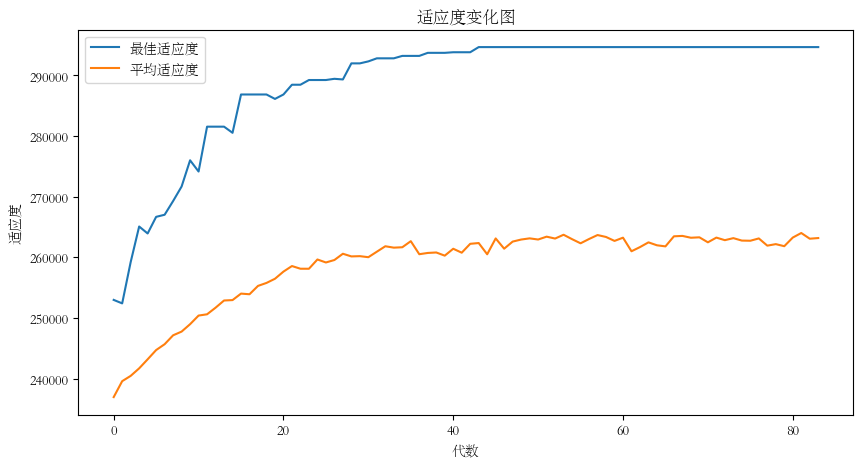

覆盖率：46.29%
已保存 71 个最佳候选点到文件 '../result/求阈值/最佳监测点_20_points.shp'
第 2 次运行...
Generation 0: Best Fitness = 253688.796875
Generation 1: Best Fitness = 258789.578125
Generation 2: Best Fitness = 260611.859375
Generation 3: Best Fitness = 263329.5625
Generation 4: Best Fitness = 264232.4375
Generation 5: Best Fitness = 268075.84375
Generation 6: Best Fitness = 267757.5625
Generation 7: Best Fitness = 269788.8125
Generation 8: Best Fitness = 272175.34375
Generation 9: Best Fitness = 274940.40625
Generation 10: Best Fitness = 274940.40625
Generation 11: Best Fitness = 274940.40625
Generation 12: Best Fitness = 276434.0
Generation 13: Best Fitness = 277177.0
Generation 14: Best Fitness = 278121.6875
Generation 15: Best Fitness = 278563.09375
Generation 16: Best Fitness = 281775.53125
Generation 17: Best Fitness = 282290.84375
Generation 18: Best Fitness = 282290.84375
Generation 19: Best Fitness = 282711.65625
Generation 20: Best Fitness = 282914.6875
Generation 21: Best Fitness = 283201.40625


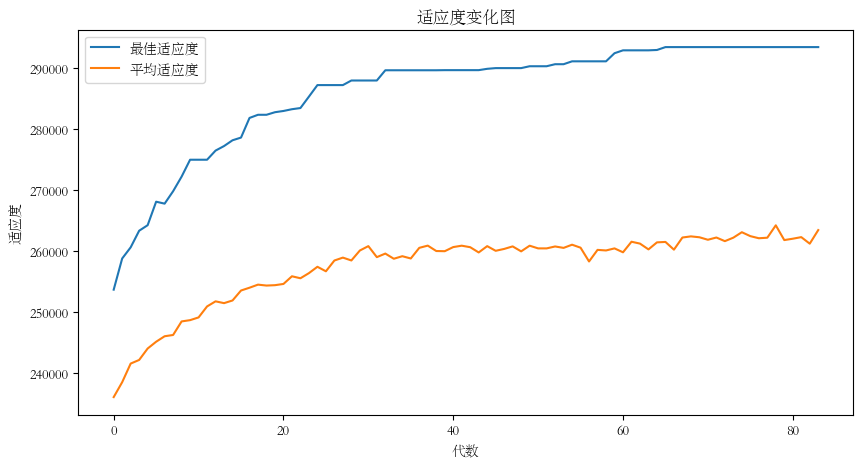

覆盖率：46.08%
已保存 71 个最佳候选点到文件 '../result/求阈值/最佳监测点_20_points.shp'
第 3 次运行...
Generation 0: Best Fitness = 252063.328125
Generation 1: Best Fitness = 252705.375
Generation 2: Best Fitness = 256044.40625
Generation 3: Best Fitness = 256213.953125
Generation 4: Best Fitness = 264850.625
Generation 5: Best Fitness = 265779.375
Generation 6: Best Fitness = 265610.875
Generation 7: Best Fitness = 269047.59375
Generation 8: Best Fitness = 272951.9375
Generation 9: Best Fitness = 272951.9375
Generation 10: Best Fitness = 275605.5
Generation 11: Best Fitness = 277645.53125
Generation 12: Best Fitness = 277499.9375
Generation 13: Best Fitness = 278444.1875
Generation 14: Best Fitness = 278444.1875
Generation 15: Best Fitness = 279638.0625
Generation 16: Best Fitness = 279638.0625
Generation 17: Best Fitness = 280165.3125
Generation 18: Best Fitness = 283202.5625
Generation 19: Best Fitness = 282837.5625
Generation 20: Best Fitness = 284864.125
Generation 21: Best Fitness = 284864.125
Generation 22

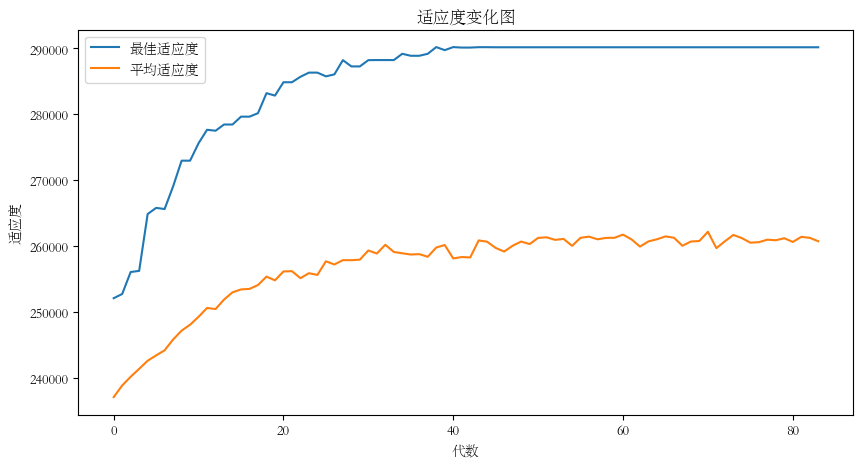

覆盖率：45.58%
已保存 71 个最佳候选点到文件 '../result/求阈值/最佳监测点_20_points.shp'
新增监测点数：20 - 最佳覆盖率：46.29%
运行遗传算法，新增监测点数量：40
调整后的最大迭代次数（对数增长）: 99
第 1 次运行...
Generation 0: Best Fitness = 297459.40625
Generation 1: Best Fitness = 300295.8125
Generation 2: Best Fitness = 304277.5625
Generation 3: Best Fitness = 313147.75
Generation 4: Best Fitness = 317477.4375
Generation 5: Best Fitness = 317477.4375
Generation 6: Best Fitness = 318115.5
Generation 7: Best Fitness = 324894.6875
Generation 8: Best Fitness = 324742.65625
Generation 9: Best Fitness = 329855.96875
Generation 10: Best Fitness = 331548.71875
Generation 11: Best Fitness = 333866.84375
Generation 12: Best Fitness = 335015.6875
Generation 13: Best Fitness = 336359.09375
Generation 14: Best Fitness = 337304.0625
Generation 15: Best Fitness = 340702.125
Generation 16: Best Fitness = 340763.75
Generation 17: Best Fitness = 343569.96875
Generation 18: Best Fitness = 343569.96875
Generation 19: Best Fitness = 345707.40625
Generation 20: Best Fitness = 

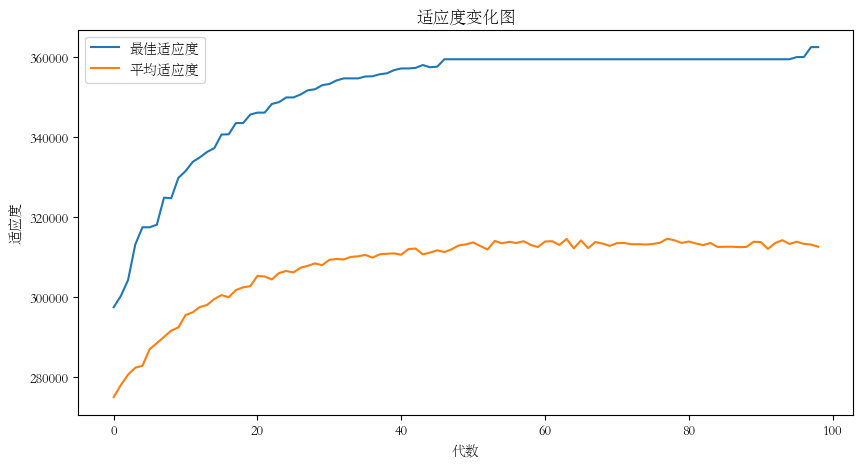

覆盖率：56.96%
已保存 91 个最佳候选点到文件 '../result/求阈值/最佳监测点_40_points.shp'
第 2 次运行...
Generation 0: Best Fitness = 295231.25
Generation 1: Best Fitness = 302845.03125
Generation 2: Best Fitness = 307715.03125
Generation 3: Best Fitness = 308644.78125
Generation 4: Best Fitness = 312148.59375
Generation 5: Best Fitness = 314088.5
Generation 6: Best Fitness = 318187.0
Generation 7: Best Fitness = 320431.96875
Generation 8: Best Fitness = 326353.15625
Generation 9: Best Fitness = 326353.15625
Generation 10: Best Fitness = 326353.15625
Generation 11: Best Fitness = 328731.59375
Generation 12: Best Fitness = 331093.6875
Generation 13: Best Fitness = 337303.28125
Generation 14: Best Fitness = 334906.21875
Generation 15: Best Fitness = 335294.0625
Generation 16: Best Fitness = 335294.0625
Generation 17: Best Fitness = 337528.0
Generation 18: Best Fitness = 338718.78125
Generation 19: Best Fitness = 338718.78125
Generation 20: Best Fitness = 343591.40625
Generation 21: Best Fitness = 343591.40625
Generat

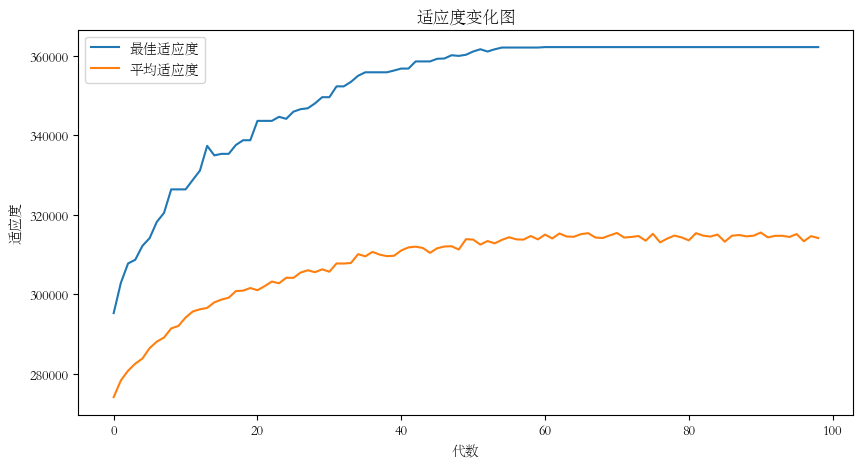

覆盖率：56.89%
已保存 91 个最佳候选点到文件 '../result/求阈值/最佳监测点_40_points.shp'
第 3 次运行...
Generation 0: Best Fitness = 293319.4375
Generation 1: Best Fitness = 301794.4375
Generation 2: Best Fitness = 305043.96875
Generation 3: Best Fitness = 308680.90625
Generation 4: Best Fitness = 308680.90625
Generation 5: Best Fitness = 310821.5
Generation 6: Best Fitness = 313525.40625
Generation 7: Best Fitness = 315189.375
Generation 8: Best Fitness = 317060.40625
Generation 9: Best Fitness = 320267.28125
Generation 10: Best Fitness = 325142.25
Generation 11: Best Fitness = 325142.25
Generation 12: Best Fitness = 326482.71875
Generation 13: Best Fitness = 326482.71875
Generation 14: Best Fitness = 330063.65625
Generation 15: Best Fitness = 330176.125
Generation 16: Best Fitness = 333051.3125
Generation 17: Best Fitness = 333051.3125
Generation 18: Best Fitness = 334738.21875
Generation 19: Best Fitness = 337129.53125
Generation 20: Best Fitness = 337129.53125
Generation 21: Best Fitness = 339304.84375
Generat

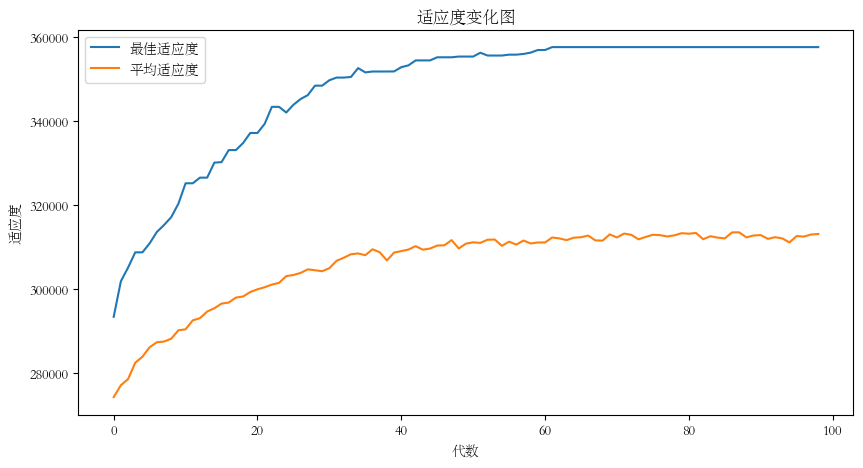

覆盖率：56.17%
已保存 91 个最佳候选点到文件 '../result/求阈值/最佳监测点_40_points.shp'
新增监测点数：40 - 最佳覆盖率：56.96%
运行遗传算法，新增监测点数量：60
调整后的最大迭代次数（对数增长）: 106
第 1 次运行...
Generation 0: Best Fitness = 346015.0
Generation 1: Best Fitness = 345619.25
Generation 2: Best Fitness = 351436.90625
Generation 3: Best Fitness = 353021.3125
Generation 4: Best Fitness = 356452.84375
Generation 5: Best Fitness = 363308.9375
Generation 6: Best Fitness = 363308.9375
Generation 7: Best Fitness = 367244.0625
Generation 8: Best Fitness = 368890.28125
Generation 9: Best Fitness = 372477.25
Generation 10: Best Fitness = 372724.75
Generation 11: Best Fitness = 375976.46875
Generation 12: Best Fitness = 377732.84375
Generation 13: Best Fitness = 381336.09375
Generation 14: Best Fitness = 381954.625
Generation 15: Best Fitness = 383475.8125
Generation 16: Best Fitness = 387301.375
Generation 17: Best Fitness = 386987.75
Generation 18: Best Fitness = 388515.78125
Generation 19: Best Fitness = 391349.28125
Generation 20: Best Fitness = 39335

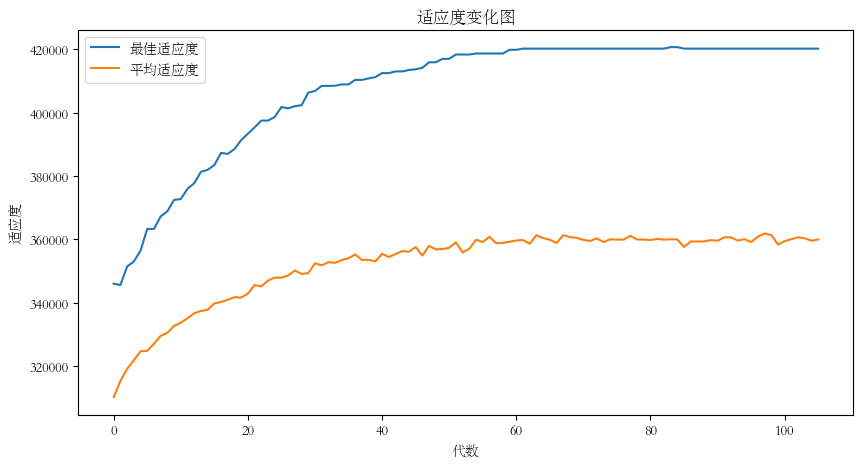

覆盖率：66.01%
已保存 111 个最佳候选点到文件 '../result/求阈值/最佳监测点_60_points.shp'
第 2 次运行...
Generation 0: Best Fitness = 334735.625
Generation 1: Best Fitness = 341497.15625
Generation 2: Best Fitness = 343827.15625
Generation 3: Best Fitness = 350006.3125
Generation 4: Best Fitness = 353403.15625
Generation 5: Best Fitness = 357862.40625
Generation 6: Best Fitness = 359634.59375
Generation 7: Best Fitness = 359792.53125
Generation 8: Best Fitness = 365901.0625
Generation 9: Best Fitness = 367714.0625
Generation 10: Best Fitness = 369511.375
Generation 11: Best Fitness = 374050.40625
Generation 12: Best Fitness = 374050.40625
Generation 13: Best Fitness = 375603.6875
Generation 14: Best Fitness = 379706.15625
Generation 15: Best Fitness = 379787.4375
Generation 16: Best Fitness = 381985.9375
Generation 17: Best Fitness = 384162.96875
Generation 18: Best Fitness = 384959.34375
Generation 19: Best Fitness = 388078.8125
Generation 20: Best Fitness = 390245.28125
Generation 21: Best Fitness = 390245.28125

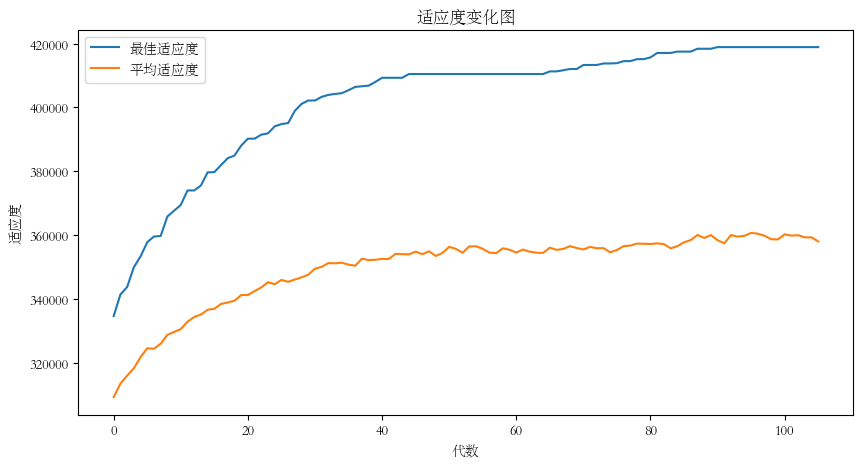

覆盖率：65.80%
已保存 111 个最佳候选点到文件 '../result/求阈值/最佳监测点_60_points.shp'
第 3 次运行...
Generation 0: Best Fitness = 335704.96875
Generation 1: Best Fitness = 349957.625
Generation 2: Best Fitness = 349957.625
Generation 3: Best Fitness = 354062.0
Generation 4: Best Fitness = 363000.375
Generation 5: Best Fitness = 360715.96875
Generation 6: Best Fitness = 364942.0625
Generation 7: Best Fitness = 369260.84375
Generation 8: Best Fitness = 372642.21875
Generation 9: Best Fitness = 376152.40625
Generation 10: Best Fitness = 385615.5
Generation 11: Best Fitness = 383050.875
Generation 12: Best Fitness = 384193.84375
Generation 13: Best Fitness = 389080.40625
Generation 14: Best Fitness = 388096.9375
Generation 15: Best Fitness = 390863.46875
Generation 16: Best Fitness = 390870.90625
Generation 17: Best Fitness = 392125.34375
Generation 18: Best Fitness = 394921.0
Generation 19: Best Fitness = 397712.3125
Generation 20: Best Fitness = 397712.3125
Generation 21: Best Fitness = 398401.21875
Generation 2

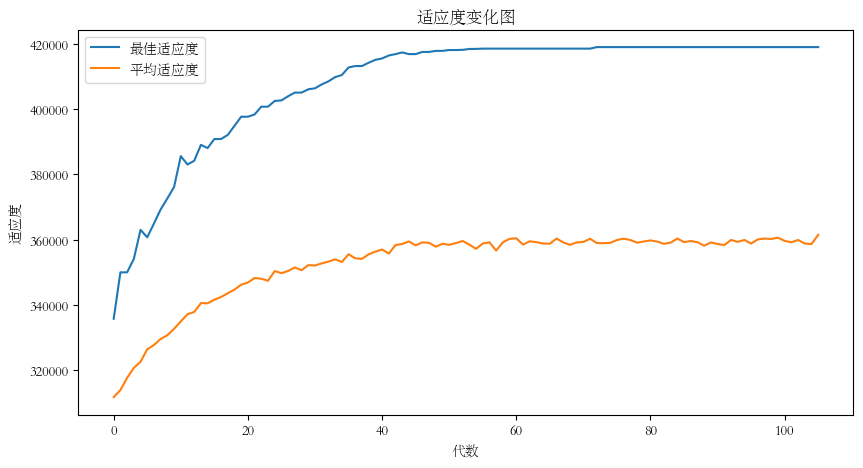

覆盖率：65.83%
已保存 111 个最佳候选点到文件 '../result/求阈值/最佳监测点_60_points.shp'
新增监测点数：60 - 最佳覆盖率：66.01%
运行遗传算法，新增监测点数量：80
调整后的最大迭代次数（对数增长）: 111
第 1 次运行...
Generation 0: Best Fitness = 370774.46875
Generation 1: Best Fitness = 384571.71875
Generation 2: Best Fitness = 382873.71875
Generation 3: Best Fitness = 386310.875
Generation 4: Best Fitness = 391100.3125
Generation 5: Best Fitness = 395408.375
Generation 6: Best Fitness = 403504.28125
Generation 7: Best Fitness = 404457.9375
Generation 8: Best Fitness = 407988.4375
Generation 9: Best Fitness = 412932.96875
Generation 10: Best Fitness = 413908.25
Generation 11: Best Fitness = 418152.5625
Generation 12: Best Fitness = 420597.46875
Generation 13: Best Fitness = 421648.59375
Generation 14: Best Fitness = 424112.3125
Generation 15: Best Fitness = 426619.53125
Generation 16: Best Fitness = 426213.25
Generation 17: Best Fitness = 430899.8125
Generation 18: Best Fitness = 432390.59375
Generation 19: Best Fitness = 435049.78125
Generation 20: Best Fitne

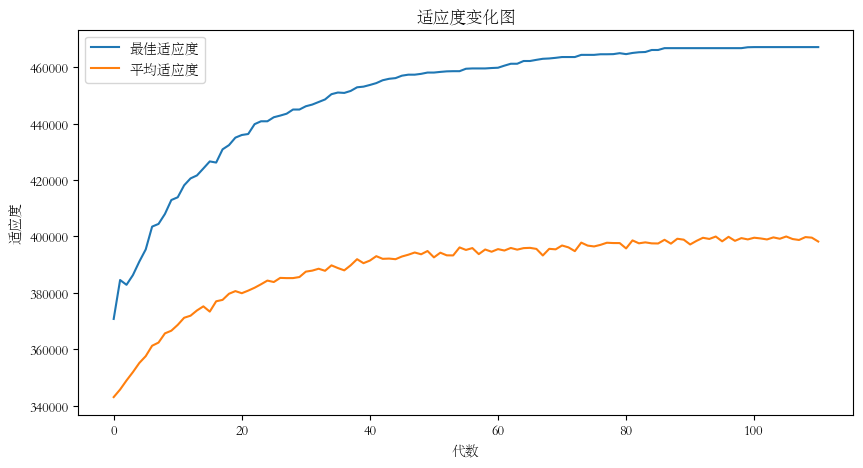

覆盖率：73.38%
已保存 131 个最佳候选点到文件 '../result/求阈值/最佳监测点_80_points.shp'
第 2 次运行...
Generation 0: Best Fitness = 374661.59375
Generation 1: Best Fitness = 386953.5
Generation 2: Best Fitness = 388002.09375
Generation 3: Best Fitness = 393720.09375
Generation 4: Best Fitness = 394173.75
Generation 5: Best Fitness = 397455.09375
Generation 6: Best Fitness = 402085.5625
Generation 7: Best Fitness = 406804.71875
Generation 8: Best Fitness = 411266.71875
Generation 9: Best Fitness = 415032.40625
Generation 10: Best Fitness = 417928.125
Generation 11: Best Fitness = 422787.0625
Generation 12: Best Fitness = 422707.9375
Generation 13: Best Fitness = 423664.0625
Generation 14: Best Fitness = 429103.90625
Generation 15: Best Fitness = 429324.8125
Generation 16: Best Fitness = 433150.125
Generation 17: Best Fitness = 433651.71875
Generation 18: Best Fitness = 435002.9375
Generation 19: Best Fitness = 435002.9375
Generation 20: Best Fitness = 435598.1875
Generation 21: Best Fitness = 436886.03125
Generat

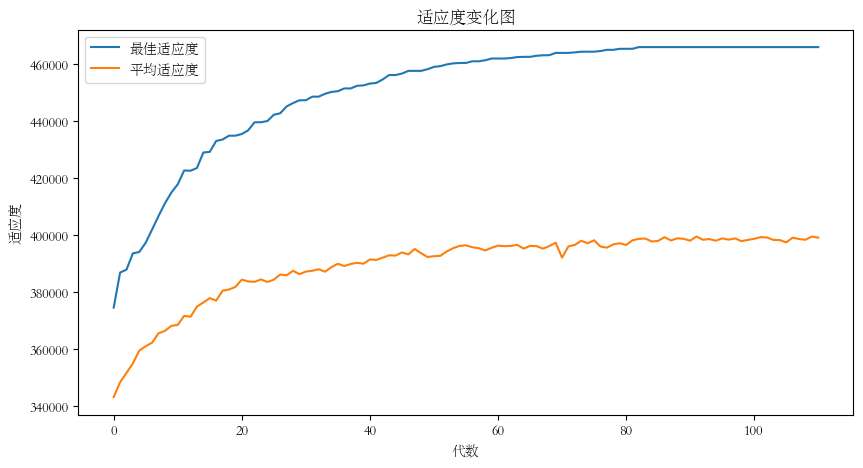

覆盖率：73.22%
已保存 131 个最佳候选点到文件 '../result/求阈值/最佳监测点_80_points.shp'
第 3 次运行...
Generation 0: Best Fitness = 367795.46875
Generation 1: Best Fitness = 375980.90625
Generation 2: Best Fitness = 382199.40625
Generation 3: Best Fitness = 387208.15625
Generation 4: Best Fitness = 391146.125
Generation 5: Best Fitness = 398228.75
Generation 6: Best Fitness = 404604.28125
Generation 7: Best Fitness = 409553.75
Generation 8: Best Fitness = 411228.3125
Generation 9: Best Fitness = 415883.53125
Generation 10: Best Fitness = 417403.03125
Generation 11: Best Fitness = 418169.0625
Generation 12: Best Fitness = 419293.59375
Generation 13: Best Fitness = 420111.53125
Generation 14: Best Fitness = 421267.71875
Generation 15: Best Fitness = 423894.90625
Generation 16: Best Fitness = 423894.90625
Generation 17: Best Fitness = 425349.90625
Generation 18: Best Fitness = 427153.25
Generation 19: Best Fitness = 429562.0625
Generation 20: Best Fitness = 433350.78125
Generation 21: Best Fitness = 436409.71875
Ge

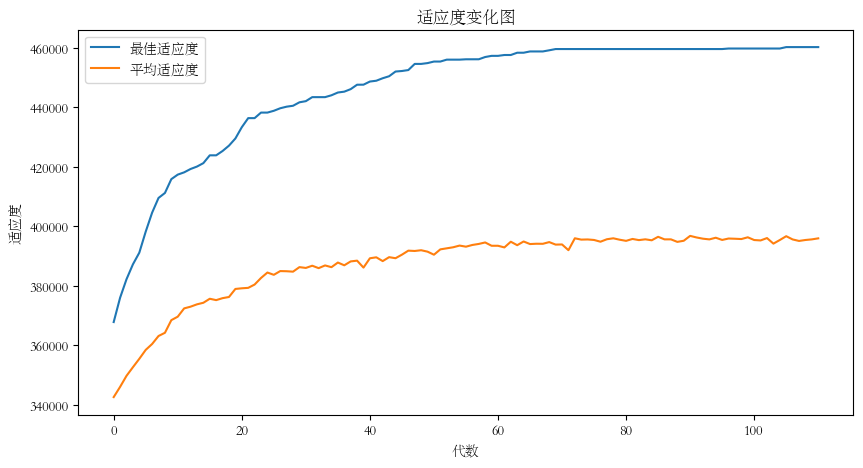

覆盖率：72.31%
已保存 131 个最佳候选点到文件 '../result/求阈值/最佳监测点_80_points.shp'
新增监测点数：80 - 最佳覆盖率：73.38%
运行遗传算法，新增监测点数量：100
调整后的最大迭代次数（对数增长）: 115
第 1 次运行...
Generation 0: Best Fitness = 401773.71875
Generation 1: Best Fitness = 407090.71875
Generation 2: Best Fitness = 416896.21875
Generation 3: Best Fitness = 421257.34375
Generation 4: Best Fitness = 426721.53125
Generation 5: Best Fitness = 429960.15625
Generation 6: Best Fitness = 432326.09375
Generation 7: Best Fitness = 435633.5625
Generation 8: Best Fitness = 440141.09375
Generation 9: Best Fitness = 442855.0
Generation 10: Best Fitness = 445056.28125
Generation 11: Best Fitness = 446841.40625
Generation 12: Best Fitness = 447933.53125
Generation 13: Best Fitness = 452612.53125
Generation 14: Best Fitness = 454307.65625
Generation 15: Best Fitness = 457493.34375
Generation 16: Best Fitness = 459483.1875
Generation 17: Best Fitness = 462192.0
Generation 18: Best Fitness = 465127.5625
Generation 19: Best Fitness = 468246.75
Generation 20: Best Fi

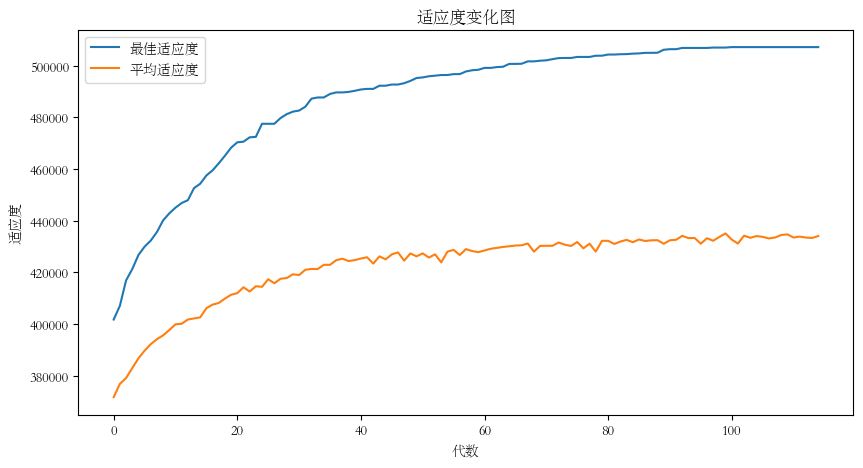

覆盖率：79.67%
已保存 151 个最佳候选点到文件 '../result/求阈值/最佳监测点_100_points.shp'
第 2 次运行...
Generation 0: Best Fitness = 407640.6875
Generation 1: Best Fitness = 409213.34375
Generation 2: Best Fitness = 416712.03125
Generation 3: Best Fitness = 420567.25
Generation 4: Best Fitness = 430366.59375
Generation 5: Best Fitness = 433832.4375
Generation 6: Best Fitness = 436894.53125
Generation 7: Best Fitness = 442583.875
Generation 8: Best Fitness = 445864.53125
Generation 9: Best Fitness = 448465.5625
Generation 10: Best Fitness = 452472.65625
Generation 11: Best Fitness = 456348.25
Generation 12: Best Fitness = 457182.625
Generation 13: Best Fitness = 462536.15625
Generation 14: Best Fitness = 462611.40625
Generation 15: Best Fitness = 462841.4375
Generation 16: Best Fitness = 465112.5625
Generation 17: Best Fitness = 466214.59375
Generation 18: Best Fitness = 467743.1875
Generation 19: Best Fitness = 469755.875
Generation 20: Best Fitness = 472354.34375
Generation 21: Best Fitness = 472354.34375
Gener

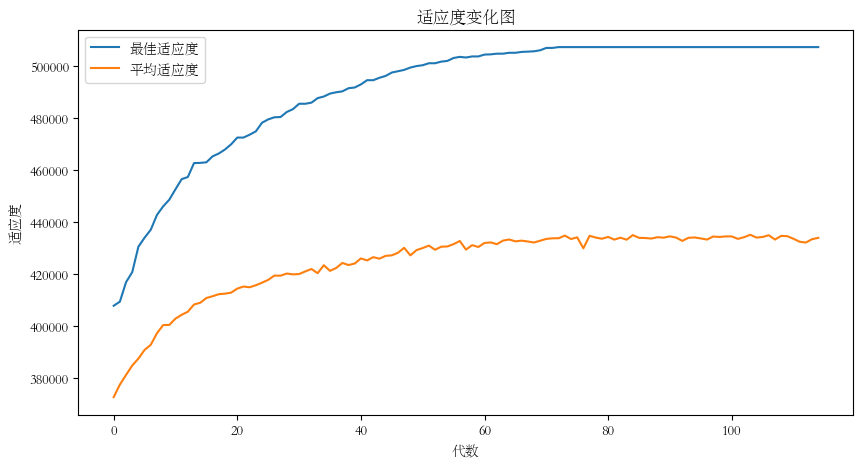

覆盖率：79.67%
已保存 151 个最佳候选点到文件 '../result/求阈值/最佳监测点_100_points.shp'
第 3 次运行...
Generation 0: Best Fitness = 398667.59375
Generation 1: Best Fitness = 403362.0
Generation 2: Best Fitness = 409040.28125
Generation 3: Best Fitness = 417366.25
Generation 4: Best Fitness = 426266.1875
Generation 5: Best Fitness = 430061.9375
Generation 6: Best Fitness = 430061.9375
Generation 7: Best Fitness = 437048.65625
Generation 8: Best Fitness = 441804.75
Generation 9: Best Fitness = 442058.15625
Generation 10: Best Fitness = 444533.71875
Generation 11: Best Fitness = 445692.5
Generation 12: Best Fitness = 447788.3125
Generation 13: Best Fitness = 448366.84375
Generation 14: Best Fitness = 448873.71875
Generation 15: Best Fitness = 452310.71875
Generation 16: Best Fitness = 454690.59375
Generation 17: Best Fitness = 457003.03125
Generation 18: Best Fitness = 460299.03125
Generation 19: Best Fitness = 462310.375
Generation 20: Best Fitness = 463358.84375
Generation 21: Best Fitness = 465043.84375
Generat

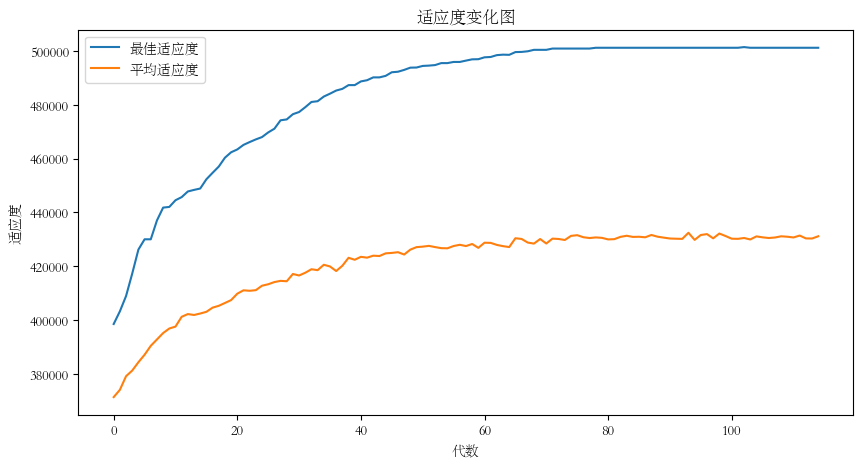

覆盖率：78.71%
已保存 151 个最佳候选点到文件 '../result/求阈值/最佳监测点_100_points.shp'
新增监测点数：100 - 最佳覆盖率：79.67%
运行遗传算法，新增监测点数量：120
调整后的最大迭代次数（对数增长）: 117
第 1 次运行...
Generation 0: Best Fitness = 428034.21875
Generation 1: Best Fitness = 438591.78125
Generation 2: Best Fitness = 441832.53125
Generation 3: Best Fitness = 445701.1875
Generation 4: Best Fitness = 455541.84375
Generation 5: Best Fitness = 456788.25
Generation 6: Best Fitness = 464960.8125
Generation 7: Best Fitness = 467389.75
Generation 8: Best Fitness = 475126.71875
Generation 9: Best Fitness = 475365.28125
Generation 10: Best Fitness = 479938.78125
Generation 11: Best Fitness = 482212.9375
Generation 12: Best Fitness = 482616.0
Generation 13: Best Fitness = 484629.28125
Generation 14: Best Fitness = 488732.625
Generation 15: Best Fitness = 488812.5
Generation 16: Best Fitness = 492183.1875
Generation 17: Best Fitness = 493571.8125
Generation 18: Best Fitness = 494861.5
Generation 19: Best Fitness = 497973.8125
Generation 20: Best Fitness = 49

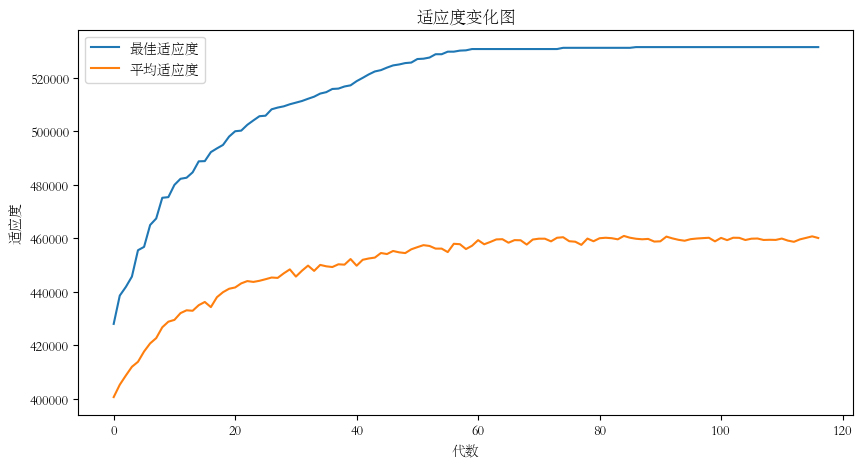

覆盖率：83.47%
已保存 171 个最佳候选点到文件 '../result/求阈值/最佳监测点_120_points.shp'
第 2 次运行...
Generation 0: Best Fitness = 428889.65625
Generation 1: Best Fitness = 436889.6875
Generation 2: Best Fitness = 445030.1875
Generation 3: Best Fitness = 453260.71875
Generation 4: Best Fitness = 455498.8125
Generation 5: Best Fitness = 463094.53125
Generation 6: Best Fitness = 463334.21875
Generation 7: Best Fitness = 470832.375
Generation 8: Best Fitness = 472972.75
Generation 9: Best Fitness = 475154.5625
Generation 10: Best Fitness = 477303.0
Generation 11: Best Fitness = 483488.8125
Generation 12: Best Fitness = 483666.78125
Generation 13: Best Fitness = 484949.15625
Generation 14: Best Fitness = 487557.4375
Generation 15: Best Fitness = 487557.4375
Generation 16: Best Fitness = 490633.375
Generation 17: Best Fitness = 491929.9375
Generation 18: Best Fitness = 494201.15625
Generation 19: Best Fitness = 495370.15625
Generation 20: Best Fitness = 498167.21875
Generation 21: Best Fitness = 499702.28125
Genera

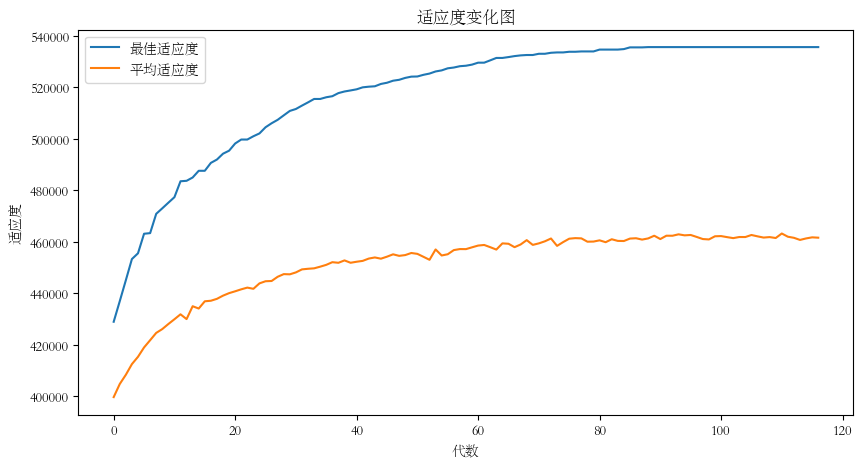

覆盖率：84.14%
已保存 171 个最佳候选点到文件 '../result/求阈值/最佳监测点_120_points.shp'
第 3 次运行...
Generation 0: Best Fitness = 430918.78125
Generation 1: Best Fitness = 437803.6875
Generation 2: Best Fitness = 442966.9375
Generation 3: Best Fitness = 448881.21875
Generation 4: Best Fitness = 454103.90625
Generation 5: Best Fitness = 459494.09375
Generation 6: Best Fitness = 465090.25
Generation 7: Best Fitness = 465090.25
Generation 8: Best Fitness = 470025.375
Generation 9: Best Fitness = 473089.375
Generation 10: Best Fitness = 474572.4375
Generation 11: Best Fitness = 478053.9375
Generation 12: Best Fitness = 481306.03125
Generation 13: Best Fitness = 487067.15625
Generation 14: Best Fitness = 488135.125
Generation 15: Best Fitness = 488615.3125
Generation 16: Best Fitness = 492253.9375
Generation 17: Best Fitness = 493120.03125
Generation 18: Best Fitness = 495827.5625
Generation 19: Best Fitness = 498230.3125
Generation 20: Best Fitness = 500484.25
Generation 21: Best Fitness = 502586.625
Generation 2

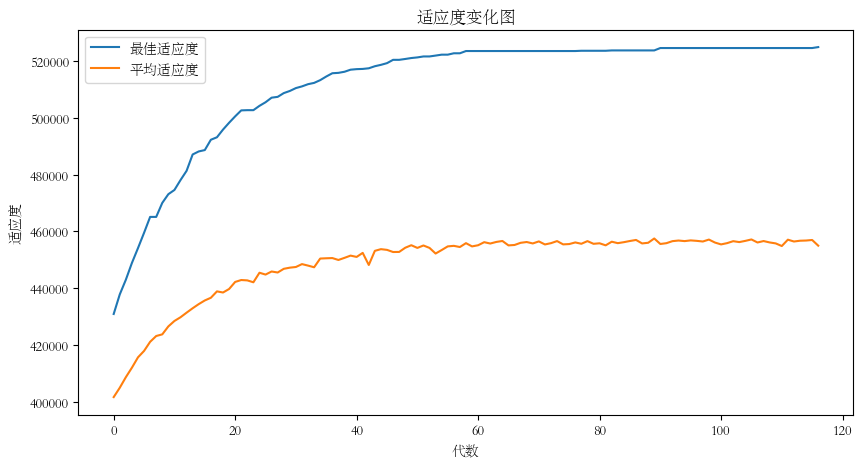

覆盖率：82.45%
已保存 171 个最佳候选点到文件 '../result/求阈值/最佳监测点_120_points.shp'
新增监测点数：120 - 最佳覆盖率：84.14%
运行遗传算法，新增监测点数量：140
调整后的最大迭代次数（对数增长）: 120
第 1 次运行...
Generation 0: Best Fitness = 455472.8125
Generation 1: Best Fitness = 460023.78125
Generation 2: Best Fitness = 470128.25
Generation 3: Best Fitness = 475316.375
Generation 4: Best Fitness = 481336.0
Generation 5: Best Fitness = 486661.96875
Generation 6: Best Fitness = 494186.46875
Generation 7: Best Fitness = 496918.28125
Generation 8: Best Fitness = 499270.53125
Generation 9: Best Fitness = 507139.25
Generation 10: Best Fitness = 509469.59375
Generation 11: Best Fitness = 511508.96875
Generation 12: Best Fitness = 512165.59375
Generation 13: Best Fitness = 513636.875
Generation 14: Best Fitness = 515579.15625
Generation 15: Best Fitness = 518043.34375
Generation 16: Best Fitness = 520319.34375
Generation 17: Best Fitness = 522469.6875
Generation 18: Best Fitness = 524542.3125
Generation 19: Best Fitness = 525330.1875
Generation 20: Best Fitn

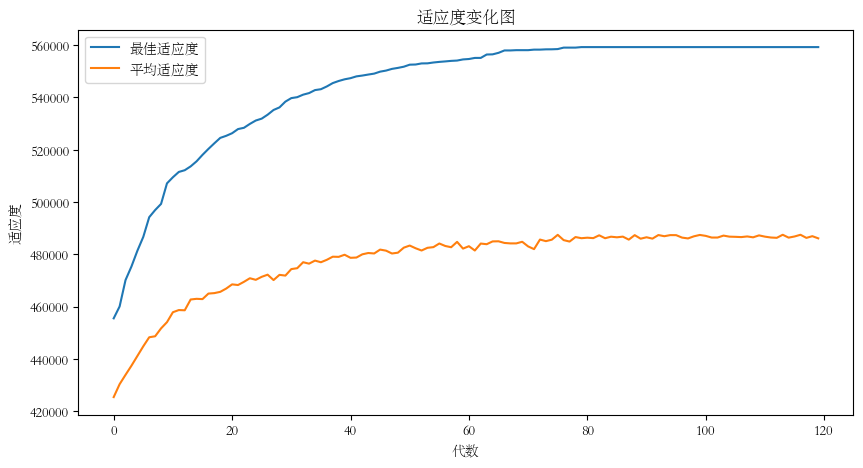

覆盖率：87.86%
已保存 191 个最佳候选点到文件 '../result/求阈值/最佳监测点_140_points.shp'
第 2 次运行...
Generation 0: Best Fitness = 460623.5625
Generation 1: Best Fitness = 462483.75
Generation 2: Best Fitness = 472558.46875
Generation 3: Best Fitness = 475751.5
Generation 4: Best Fitness = 478246.9375
Generation 5: Best Fitness = 480381.0
Generation 6: Best Fitness = 483506.3125
Generation 7: Best Fitness = 485423.625
Generation 8: Best Fitness = 491592.0625
Generation 9: Best Fitness = 494592.03125
Generation 10: Best Fitness = 501671.40625
Generation 11: Best Fitness = 503595.28125
Generation 12: Best Fitness = 508722.0625
Generation 13: Best Fitness = 510630.4375
Generation 14: Best Fitness = 513748.75
Generation 15: Best Fitness = 515492.96875
Generation 16: Best Fitness = 517553.375
Generation 17: Best Fitness = 519317.9375
Generation 18: Best Fitness = 521490.25
Generation 19: Best Fitness = 523845.9375
Generation 20: Best Fitness = 525607.8125
Generation 21: Best Fitness = 530445.1875
Generation 22: Bes

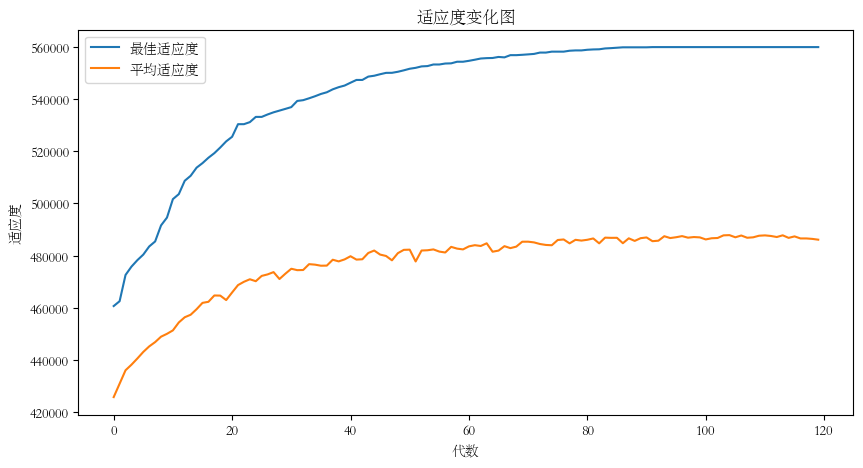

覆盖率：87.97%
已保存 191 个最佳候选点到文件 '../result/求阈值/最佳监测点_140_points.shp'
第 3 次运行...
Generation 0: Best Fitness = 455820.21875
Generation 1: Best Fitness = 470534.6875
Generation 2: Best Fitness = 472684.65625
Generation 3: Best Fitness = 475050.34375
Generation 4: Best Fitness = 490014.375
Generation 5: Best Fitness = 490014.375
Generation 6: Best Fitness = 492900.4375
Generation 7: Best Fitness = 497756.71875
Generation 8: Best Fitness = 500445.0
Generation 9: Best Fitness = 501480.75
Generation 10: Best Fitness = 504500.96875
Generation 11: Best Fitness = 506292.9375
Generation 12: Best Fitness = 509590.1875
Generation 13: Best Fitness = 511125.03125
Generation 14: Best Fitness = 512440.25
Generation 15: Best Fitness = 514622.125
Generation 16: Best Fitness = 516973.6875
Generation 17: Best Fitness = 518731.9375
Generation 18: Best Fitness = 519673.9375
Generation 19: Best Fitness = 521674.4375
Generation 20: Best Fitness = 523199.1875
Generation 21: Best Fitness = 524793.0625
Generation 22

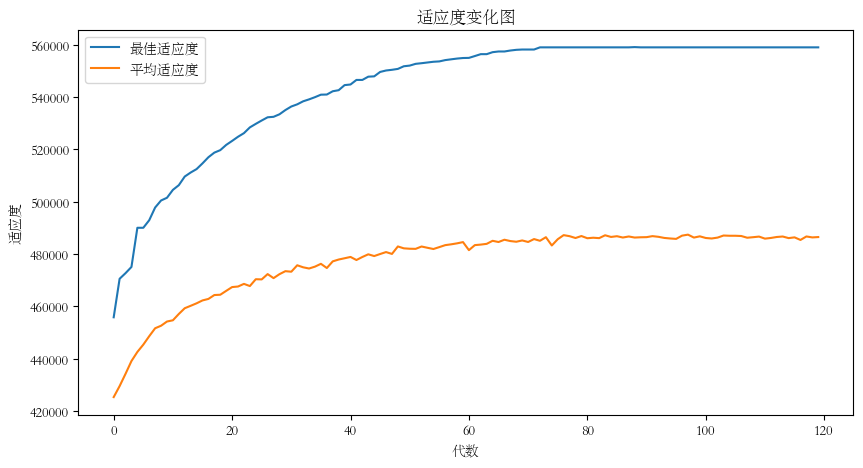

覆盖率：87.80%
已保存 191 个最佳候选点到文件 '../result/求阈值/最佳监测点_140_points.shp'
新增监测点数：140 - 最佳覆盖率：87.97%
运行遗传算法，新增监测点数量：160
调整后的最大迭代次数（对数增长）: 122
第 1 次运行...
Generation 0: Best Fitness = 475338.90625
Generation 1: Best Fitness = 480957.875
Generation 2: Best Fitness = 487303.375
Generation 3: Best Fitness = 490281.9375
Generation 4: Best Fitness = 497128.28125
Generation 5: Best Fitness = 501755.96875
Generation 6: Best Fitness = 509354.0
Generation 7: Best Fitness = 510303.0625
Generation 8: Best Fitness = 512631.1875
Generation 9: Best Fitness = 514504.21875
Generation 10: Best Fitness = 517164.96875
Generation 11: Best Fitness = 518961.8125
Generation 12: Best Fitness = 521466.03125
Generation 13: Best Fitness = 523503.09375
Generation 14: Best Fitness = 527114.625
Generation 15: Best Fitness = 527114.625
Generation 16: Best Fitness = 528067.75
Generation 17: Best Fitness = 529912.0625
Generation 18: Best Fitness = 531015.125
Generation 19: Best Fitness = 533532.375
Generation 20: Best Fitness = 

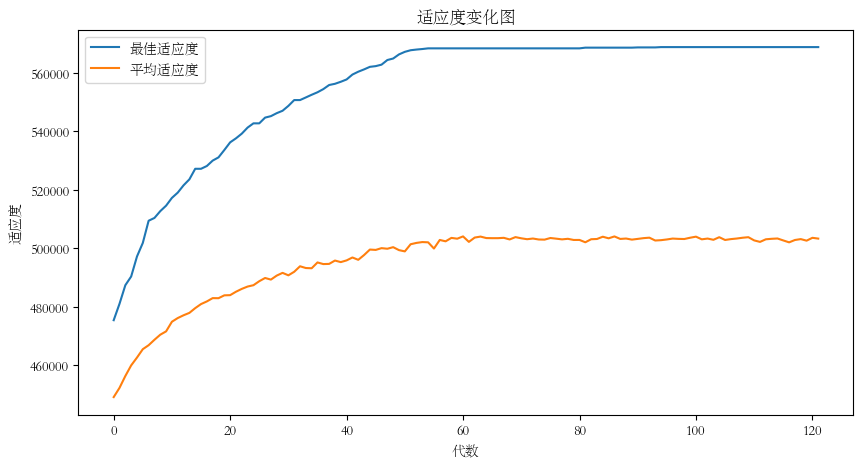

覆盖率：89.34%
已保存 211 个最佳候选点到文件 '../result/求阈值/最佳监测点_160_points.shp'
第 2 次运行...
Generation 0: Best Fitness = 483579.78125
Generation 1: Best Fitness = 498413.1875
Generation 2: Best Fitness = 498881.84375
Generation 3: Best Fitness = 500851.0625
Generation 4: Best Fitness = 506850.9375
Generation 5: Best Fitness = 515149.75
Generation 6: Best Fitness = 515149.75
Generation 7: Best Fitness = 518293.34375
Generation 8: Best Fitness = 520716.0625
Generation 9: Best Fitness = 523724.65625
Generation 10: Best Fitness = 526319.75
Generation 11: Best Fitness = 530020.4375
Generation 12: Best Fitness = 532006.25
Generation 13: Best Fitness = 532701.625
Generation 14: Best Fitness = 534780.3125
Generation 15: Best Fitness = 539895.8125
Generation 16: Best Fitness = 539895.8125
Generation 17: Best Fitness = 540879.8125
Generation 18: Best Fitness = 542401.25
Generation 19: Best Fitness = 545021.125
Generation 20: Best Fitness = 545138.5625
Generation 21: Best Fitness = 546688.4375
Generation 22: Be

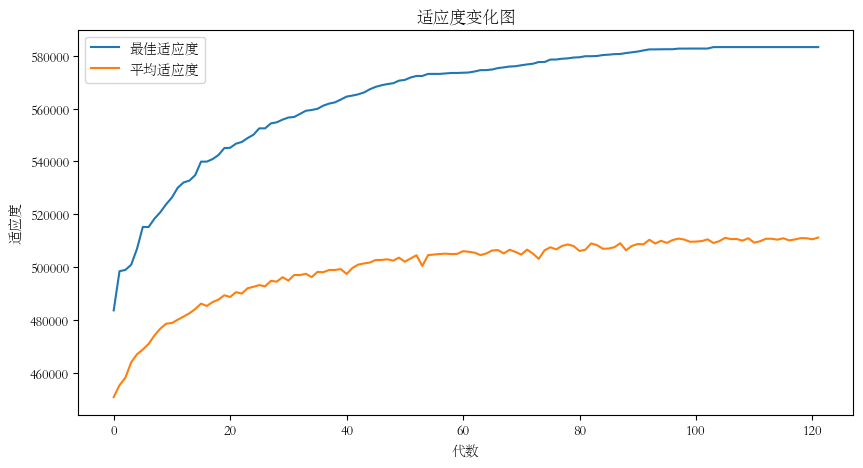

覆盖率：91.62%
已保存 211 个最佳候选点到文件 '../result/求阈值/最佳监测点_160_points.shp'
第 3 次运行...
Generation 0: Best Fitness = 489279.75
Generation 1: Best Fitness = 492347.78125
Generation 2: Best Fitness = 494002.40625
Generation 3: Best Fitness = 498465.75
Generation 4: Best Fitness = 499797.84375
Generation 5: Best Fitness = 502676.875
Generation 6: Best Fitness = 505979.375
Generation 7: Best Fitness = 507347.09375
Generation 8: Best Fitness = 510681.40625
Generation 9: Best Fitness = 511512.8125
Generation 10: Best Fitness = 513631.5
Generation 11: Best Fitness = 516137.53125
Generation 12: Best Fitness = 520495.5625
Generation 13: Best Fitness = 522829.5
Generation 14: Best Fitness = 525342.8125
Generation 15: Best Fitness = 526694.75
Generation 16: Best Fitness = 529410.5
Generation 17: Best Fitness = 531326.5
Generation 18: Best Fitness = 532767.75
Generation 19: Best Fitness = 534011.1875
Generation 20: Best Fitness = 537351.5
Generation 21: Best Fitness = 538193.625
Generation 22: Best Fitness =

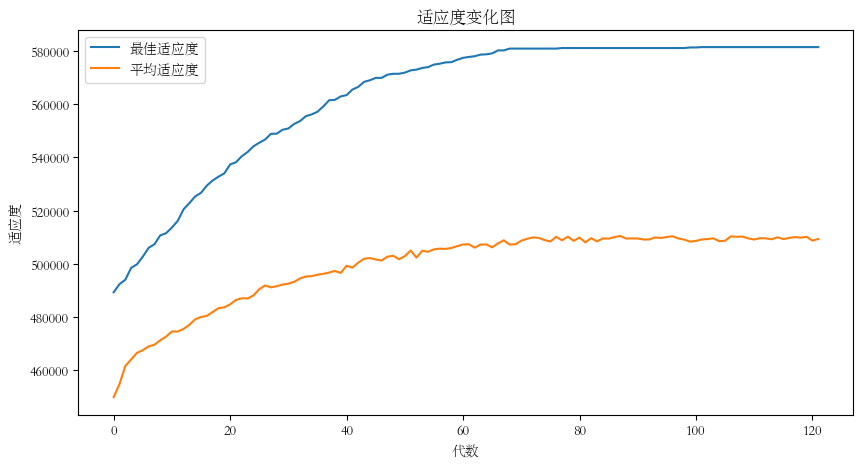

覆盖率：91.35%
已保存 211 个最佳候选点到文件 '../result/求阈值/最佳监测点_160_points.shp'
新增监测点数：160 - 最佳覆盖率：91.62%
运行遗传算法，新增监测点数量：180
调整后的最大迭代次数（对数增长）: 124
第 1 次运行...
Generation 0: Best Fitness = 503947.4375
Generation 1: Best Fitness = 509669.875
Generation 2: Best Fitness = 516102.78125
Generation 3: Best Fitness = 519569.21875
Generation 4: Best Fitness = 526579.9375
Generation 5: Best Fitness = 529788.0
Generation 6: Best Fitness = 531536.0625
Generation 7: Best Fitness = 533799.5
Generation 8: Best Fitness = 544845.375
Generation 9: Best Fitness = 543297.8125
Generation 10: Best Fitness = 544288.125
Generation 11: Best Fitness = 544521.4375
Generation 12: Best Fitness = 546255.6875
Generation 13: Best Fitness = 547555.5625
Generation 14: Best Fitness = 548807.5
Generation 15: Best Fitness = 550179.0625
Generation 16: Best Fitness = 551353.25
Generation 17: Best Fitness = 553313.8125
Generation 18: Best Fitness = 554496.375
Generation 19: Best Fitness = 556340.75
Generation 20: Best Fitness = 558914.625


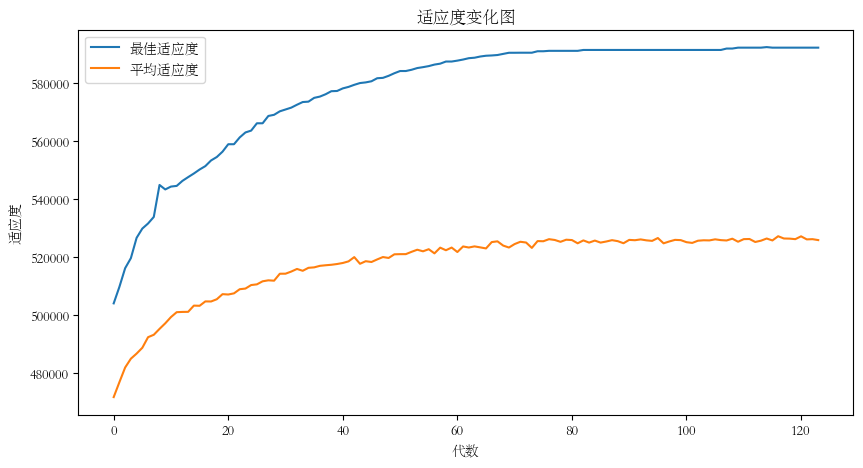

覆盖率：93.04%
已保存 231 个最佳候选点到文件 '../result/求阈值/最佳监测点_180_points.shp'
第 2 次运行...
Generation 0: Best Fitness = 505004.40625
Generation 1: Best Fitness = 510612.5625
Generation 2: Best Fitness = 515206.59375
Generation 3: Best Fitness = 516483.5
Generation 4: Best Fitness = 521006.8125
Generation 5: Best Fitness = 527674.125
Generation 6: Best Fitness = 529514.75
Generation 7: Best Fitness = 535579.0625
Generation 8: Best Fitness = 539817.875
Generation 9: Best Fitness = 541305.1875
Generation 10: Best Fitness = 543191.6875
Generation 11: Best Fitness = 545922.0625
Generation 12: Best Fitness = 547765.0625
Generation 13: Best Fitness = 549361.4375
Generation 14: Best Fitness = 552386.875
Generation 15: Best Fitness = 553143.8125
Generation 16: Best Fitness = 553673.6875
Generation 17: Best Fitness = 556093.8125
Generation 18: Best Fitness = 556711.875
Generation 19: Best Fitness = 558746.25
Generation 20: Best Fitness = 560099.5625
Generation 21: Best Fitness = 561955.25
Generation 22: Best 

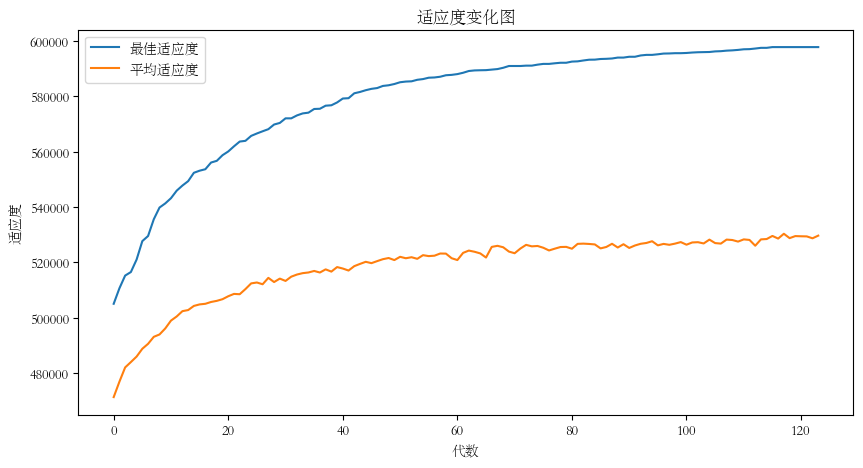

覆盖率：93.91%
已保存 231 个最佳候选点到文件 '../result/求阈值/最佳监测点_180_points.shp'
第 3 次运行...
Generation 0: Best Fitness = 504443.9375
Generation 1: Best Fitness = 510010.1875
Generation 2: Best Fitness = 511233.4375
Generation 3: Best Fitness = 520731.8125
Generation 4: Best Fitness = 524004.25
Generation 5: Best Fitness = 529320.0625
Generation 6: Best Fitness = 531553.75
Generation 7: Best Fitness = 535812.9375
Generation 8: Best Fitness = 542912.9375
Generation 9: Best Fitness = 542912.9375
Generation 10: Best Fitness = 546529.8125
Generation 11: Best Fitness = 546725.25
Generation 12: Best Fitness = 549214.0
Generation 13: Best Fitness = 550637.625
Generation 14: Best Fitness = 552394.25
Generation 15: Best Fitness = 555033.875
Generation 16: Best Fitness = 556418.75
Generation 17: Best Fitness = 557887.625
Generation 18: Best Fitness = 558723.5625
Generation 19: Best Fitness = 559671.5
Generation 20: Best Fitness = 559933.4375
Generation 21: Best Fitness = 561362.625
Generation 22: Best Fitness =

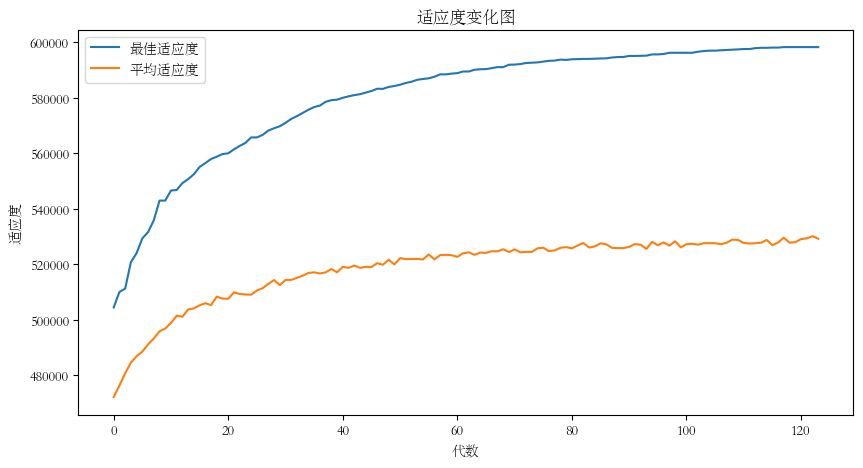

覆盖率：93.96%
已保存 231 个最佳候选点到文件 '../result/求阈值/最佳监测点_180_points.shp'
新增监测点数：180 - 最佳覆盖率：93.96%
运行遗传算法，新增监测点数量：200
调整后的最大迭代次数（对数增长）: 125
第 1 次运行...
Generation 0: Best Fitness = 518551.25
Generation 1: Best Fitness = 531292.4375
Generation 2: Best Fitness = 537362.625
Generation 3: Best Fitness = 539911.0625
Generation 4: Best Fitness = 543816.125
Generation 5: Best Fitness = 547429.75
Generation 6: Best Fitness = 551614.4375
Generation 7: Best Fitness = 551614.4375
Generation 8: Best Fitness = 556057.8125
Generation 9: Best Fitness = 557951.1875
Generation 10: Best Fitness = 560277.25
Generation 11: Best Fitness = 564693.5
Generation 12: Best Fitness = 567442.5
Generation 13: Best Fitness = 569442.9375
Generation 14: Best Fitness = 570714.875
Generation 15: Best Fitness = 574108.5625
Generation 16: Best Fitness = 577459.5
Generation 17: Best Fitness = 577526.75
Generation 18: Best Fitness = 579438.375
Generation 19: Best Fitness = 581053.75
Generation 20: Best Fitness = 581945.5625
Generat

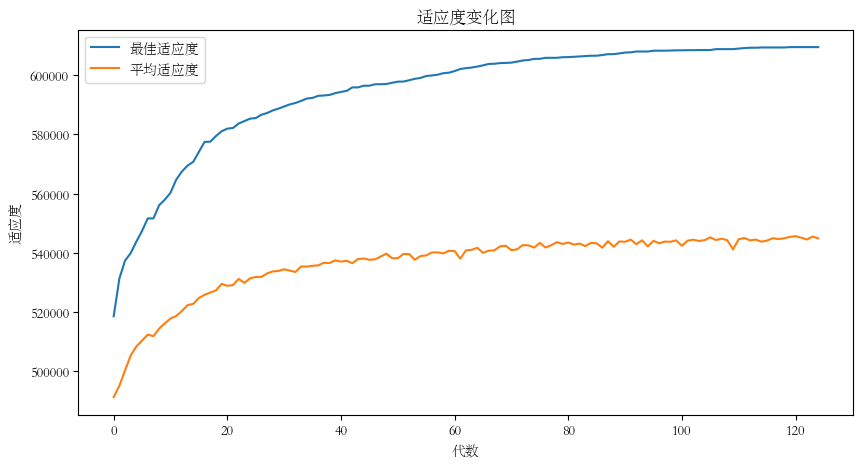

覆盖率：95.74%
已保存 251 个最佳候选点到文件 '../result/求阈值/最佳监测点_200_points.shp'
第 2 次运行...
Generation 0: Best Fitness = 521642.125
Generation 1: Best Fitness = 527259.4375
Generation 2: Best Fitness = 529049.5
Generation 3: Best Fitness = 533286.75
Generation 4: Best Fitness = 536685.625
Generation 5: Best Fitness = 543402.25
Generation 6: Best Fitness = 544968.3125
Generation 7: Best Fitness = 550588.8125
Generation 8: Best Fitness = 551792.0
Generation 9: Best Fitness = 555332.0625
Generation 10: Best Fitness = 558494.9375
Generation 11: Best Fitness = 561249.3125
Generation 12: Best Fitness = 562200.8125
Generation 13: Best Fitness = 564042.9375
Generation 14: Best Fitness = 566201.4375
Generation 15: Best Fitness = 567786.6875
Generation 16: Best Fitness = 571376.25
Generation 17: Best Fitness = 571616.5
Generation 18: Best Fitness = 573496.875
Generation 19: Best Fitness = 573928.25
Generation 20: Best Fitness = 575946.75
Generation 21: Best Fitness = 576543.5
Generation 22: Best Fitness = 5775

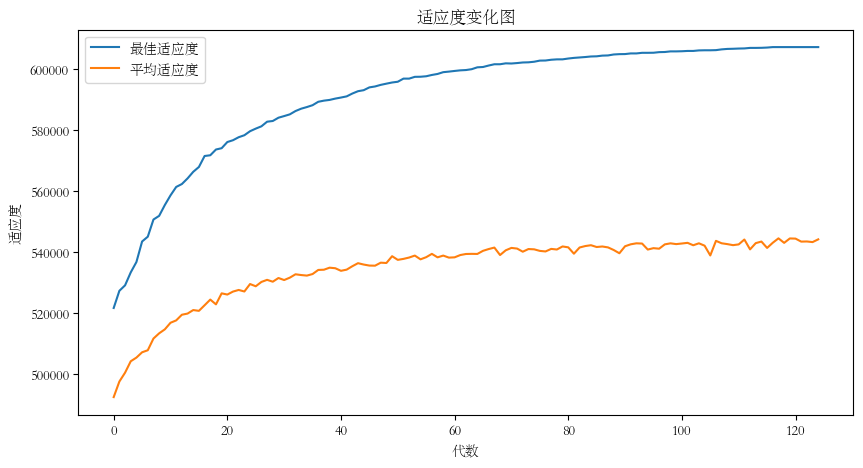

覆盖率：95.35%
已保存 251 个最佳候选点到文件 '../result/求阈值/最佳监测点_200_points.shp'
第 3 次运行...
Generation 0: Best Fitness = 527910.1875
Generation 1: Best Fitness = 527910.1875
Generation 2: Best Fitness = 532922.0
Generation 3: Best Fitness = 534047.375
Generation 4: Best Fitness = 542994.4375
Generation 5: Best Fitness = 543955.125
Generation 6: Best Fitness = 548986.3125
Generation 7: Best Fitness = 549548.8125
Generation 8: Best Fitness = 553987.5625
Generation 9: Best Fitness = 556893.875
Generation 10: Best Fitness = 558961.375
Generation 11: Best Fitness = 560151.375
Generation 12: Best Fitness = 562576.3125
Generation 13: Best Fitness = 563998.25
Generation 14: Best Fitness = 564548.0625
Generation 15: Best Fitness = 565936.8125
Generation 16: Best Fitness = 569108.1875
Generation 17: Best Fitness = 570969.6875
Generation 18: Best Fitness = 571878.0
Generation 19: Best Fitness = 576065.625
Generation 20: Best Fitness = 576508.875
Generation 21: Best Fitness = 577986.0625
Generation 22: Best Fitn

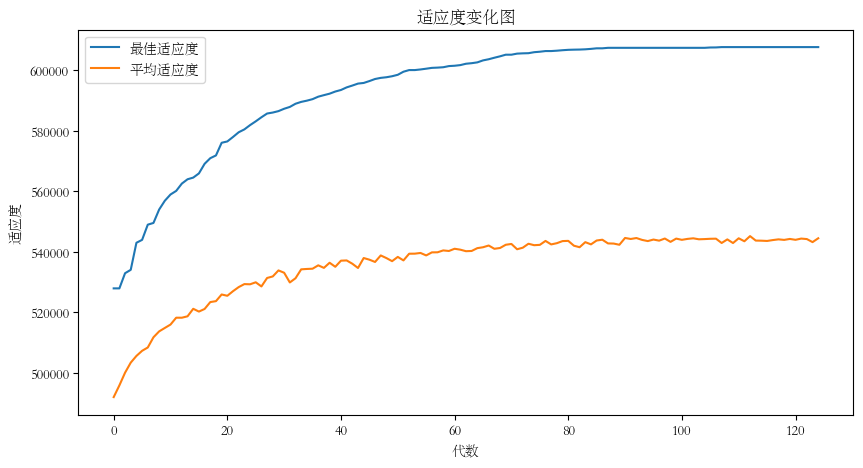

覆盖率：95.46%
已保存 251 个最佳候选点到文件 '../result/求阈值/最佳监测点_200_points.shp'
新增监测点数：200 - 最佳覆盖率：95.74%
运行遗传算法，新增监测点数量：220
调整后的最大迭代次数（对数增长）: 127
第 1 次运行...
Generation 0: Best Fitness = 532620.75
Generation 1: Best Fitness = 544561.375
Generation 2: Best Fitness = 549348.625
Generation 3: Best Fitness = 552243.5625
Generation 4: Best Fitness = 558532.3125
Generation 5: Best Fitness = 564260.3125
Generation 6: Best Fitness = 565998.3125
Generation 7: Best Fitness = 572702.25
Generation 8: Best Fitness = 572702.25
Generation 9: Best Fitness = 575228.5
Generation 10: Best Fitness = 575885.4375
Generation 11: Best Fitness = 578404.375
Generation 12: Best Fitness = 579728.1875
Generation 13: Best Fitness = 581267.5625
Generation 14: Best Fitness = 582561.125
Generation 15: Best Fitness = 584085.0
Generation 16: Best Fitness = 586106.0625
Generation 17: Best Fitness = 587065.75
Generation 18: Best Fitness = 588358.8125
Generation 19: Best Fitness = 588959.0625
Generation 20: Best Fitness = 589529.0
Gener

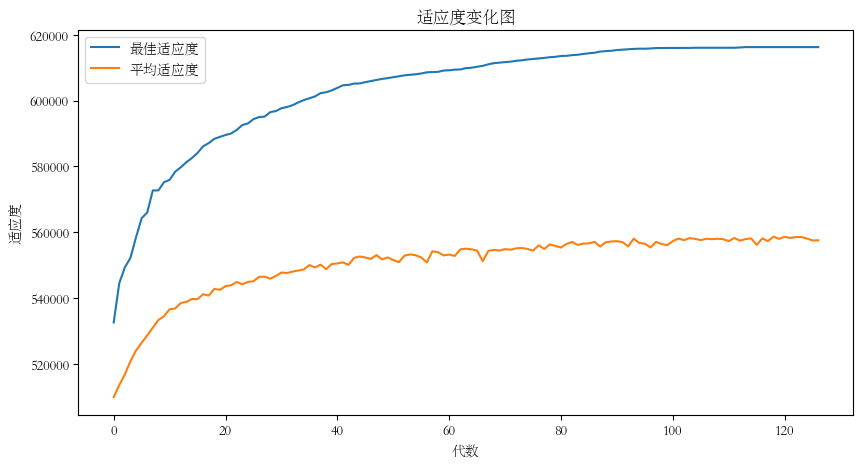

覆盖率：96.80%
已保存 271 个最佳候选点到文件 '../result/求阈值/最佳监测点_220_points.shp'
第 2 次运行...
Generation 0: Best Fitness = 538281.4375
Generation 1: Best Fitness = 543198.8125
Generation 2: Best Fitness = 550425.0625
Generation 3: Best Fitness = 555080.625
Generation 4: Best Fitness = 558885.4375
Generation 5: Best Fitness = 559731.875
Generation 6: Best Fitness = 563862.5625
Generation 7: Best Fitness = 566827.3125
Generation 8: Best Fitness = 568356.3125
Generation 9: Best Fitness = 570613.25
Generation 10: Best Fitness = 571375.25
Generation 11: Best Fitness = 574062.875
Generation 12: Best Fitness = 576428.375
Generation 13: Best Fitness = 577589.0625
Generation 14: Best Fitness = 579726.25
Generation 15: Best Fitness = 579726.25
Generation 16: Best Fitness = 582683.25
Generation 17: Best Fitness = 583398.4375
Generation 18: Best Fitness = 584995.0
Generation 19: Best Fitness = 585692.0
Generation 20: Best Fitness = 586853.6875
Generation 21: Best Fitness = 587463.625
Generation 22: Best Fitness = 

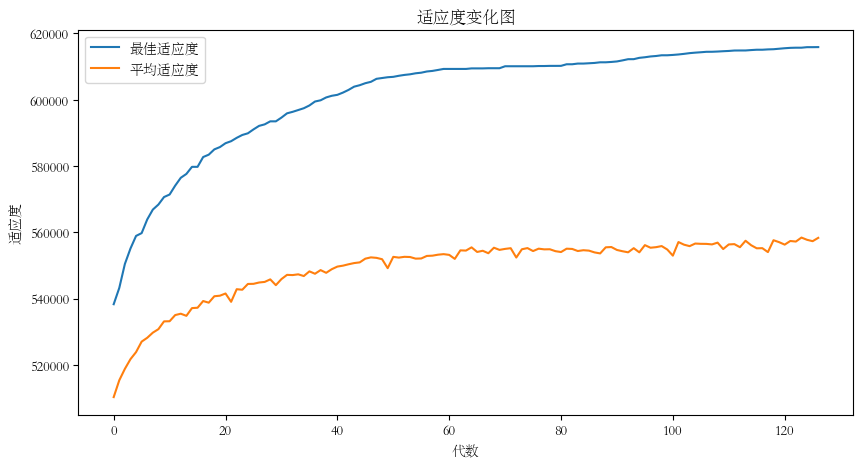

覆盖率：96.74%
已保存 271 个最佳候选点到文件 '../result/求阈值/最佳监测点_220_points.shp'
第 3 次运行...
Generation 0: Best Fitness = 537776.4375
Generation 1: Best Fitness = 541988.875
Generation 2: Best Fitness = 550015.9375
Generation 3: Best Fitness = 554976.875
Generation 4: Best Fitness = 557346.9375
Generation 5: Best Fitness = 564897.8125
Generation 6: Best Fitness = 568595.375
Generation 7: Best Fitness = 569945.0625
Generation 8: Best Fitness = 573923.875
Generation 9: Best Fitness = 573946.375
Generation 10: Best Fitness = 577810.75
Generation 11: Best Fitness = 577810.75
Generation 12: Best Fitness = 579235.625
Generation 13: Best Fitness = 580442.625
Generation 14: Best Fitness = 582558.875
Generation 15: Best Fitness = 584461.3125
Generation 16: Best Fitness = 585148.0
Generation 17: Best Fitness = 586547.125
Generation 18: Best Fitness = 586658.4375
Generation 19: Best Fitness = 587646.5
Generation 20: Best Fitness = 589283.125
Generation 21: Best Fitness = 590152.125
Generation 22: Best Fitness = 

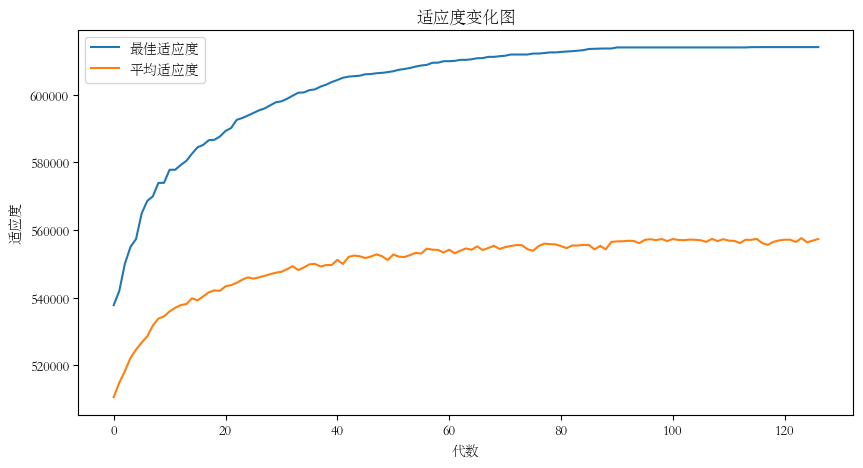

覆盖率：96.46%
已保存 271 个最佳候选点到文件 '../result/求阈值/最佳监测点_220_points.shp'
新增监测点数：220 - 最佳覆盖率：96.80%
运行遗传算法，新增监测点数量：240
调整后的最大迭代次数（对数增长）: 128
第 1 次运行...
Generation 0: Best Fitness = 552314.375
Generation 1: Best Fitness = 555651.0625
Generation 2: Best Fitness = 564161.75
Generation 3: Best Fitness = 567664.9375
Generation 4: Best Fitness = 574055.125
Generation 5: Best Fitness = 576695.125
Generation 6: Best Fitness = 578186.9375
Generation 7: Best Fitness = 579862.5
Generation 8: Best Fitness = 580788.75
Generation 9: Best Fitness = 583577.0625
Generation 10: Best Fitness = 584707.8125
Generation 11: Best Fitness = 588964.375
Generation 12: Best Fitness = 589988.25
Generation 13: Best Fitness = 591000.0625
Generation 14: Best Fitness = 592211.0625
Generation 15: Best Fitness = 593793.4375
Generation 16: Best Fitness = 595951.5625
Generation 17: Best Fitness = 596722.25
Generation 18: Best Fitness = 596900.0
Generation 19: Best Fitness = 598768.8125
Generation 20: Best Fitness = 599570.8125
Ge

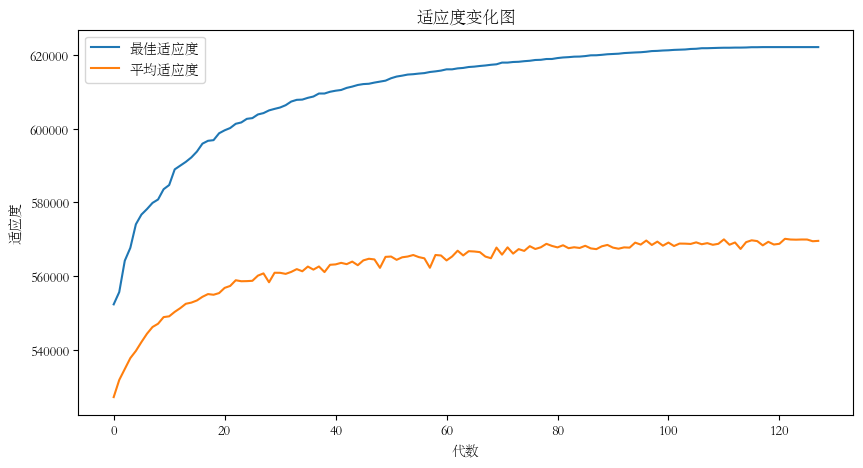

覆盖率：97.73%
已保存 291 个最佳候选点到文件 '../result/求阈值/最佳监测点_240_points.shp'
第 2 次运行...
Generation 0: Best Fitness = 553305.25
Generation 1: Best Fitness = 562866.125
Generation 2: Best Fitness = 568615.6875
Generation 3: Best Fitness = 569815.875
Generation 4: Best Fitness = 576104.625
Generation 5: Best Fitness = 582249.3125
Generation 6: Best Fitness = 581846.75
Generation 7: Best Fitness = 583085.375
Generation 8: Best Fitness = 584470.5625
Generation 9: Best Fitness = 586230.0
Generation 10: Best Fitness = 588119.25
Generation 11: Best Fitness = 590965.625
Generation 12: Best Fitness = 592325.3125
Generation 13: Best Fitness = 592937.6875
Generation 14: Best Fitness = 594500.8125
Generation 15: Best Fitness = 594900.375
Generation 16: Best Fitness = 596751.5
Generation 17: Best Fitness = 597000.4375
Generation 18: Best Fitness = 598566.5
Generation 19: Best Fitness = 599183.4375
Generation 20: Best Fitness = 599470.875
Generation 21: Best Fitness = 600134.5625
Generation 22: Best Fitness = 6

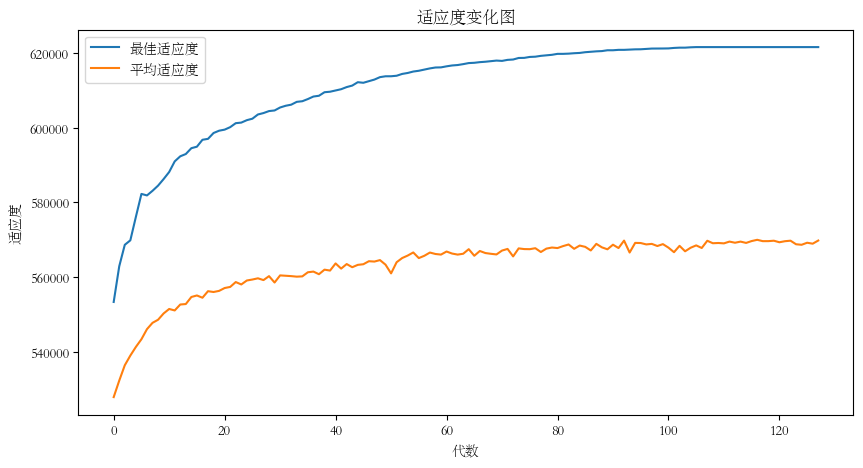

覆盖率：97.64%
已保存 291 个最佳候选点到文件 '../result/求阈值/最佳监测点_240_points.shp'
第 3 次运行...
Generation 0: Best Fitness = 554841.75
Generation 1: Best Fitness = 559141.5625
Generation 2: Best Fitness = 573877.6875
Generation 3: Best Fitness = 577060.9375
Generation 4: Best Fitness = 577422.4375
Generation 5: Best Fitness = 579183.9375
Generation 6: Best Fitness = 581651.625
Generation 7: Best Fitness = 582861.8125
Generation 8: Best Fitness = 584695.8125
Generation 9: Best Fitness = 587067.5
Generation 10: Best Fitness = 588563.3125
Generation 11: Best Fitness = 589906.875
Generation 12: Best Fitness = 591852.625
Generation 13: Best Fitness = 592413.125
Generation 14: Best Fitness = 593887.375
Generation 15: Best Fitness = 596605.0
Generation 16: Best Fitness = 596803.8125
Generation 17: Best Fitness = 597570.875
Generation 18: Best Fitness = 598570.1875
Generation 19: Best Fitness = 598982.8125
Generation 20: Best Fitness = 600245.25
Generation 21: Best Fitness = 602200.5625
Generation 22: Best Fitne

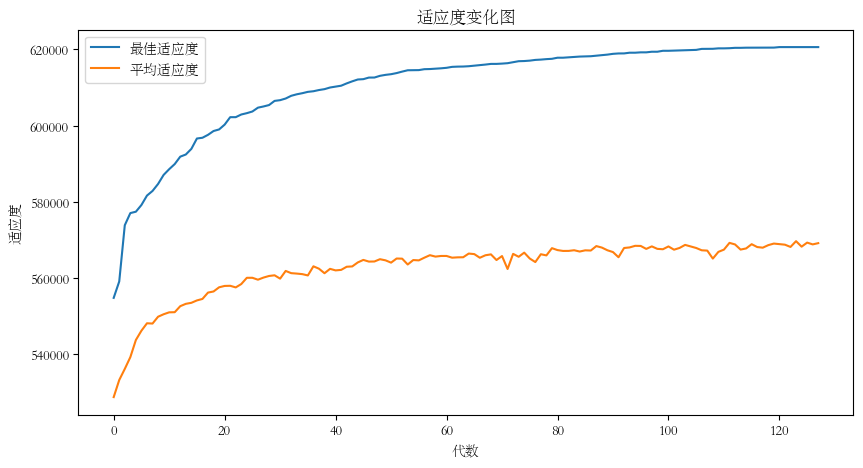

覆盖率：97.48%
已保存 291 个最佳候选点到文件 '../result/求阈值/最佳监测点_240_points.shp'
新增监测点数：240 - 最佳覆盖率：97.73%
运行遗传算法，新增监测点数量：260
调整后的最大迭代次数（对数增长）: 129
第 1 次运行...
Generation 0: Best Fitness = 566952.3125
Generation 1: Best Fitness = 569444.0
Generation 2: Best Fitness = 578831.4375
Generation 3: Best Fitness = 583341.4375
Generation 4: Best Fitness = 585244.25
Generation 5: Best Fitness = 587519.875
Generation 6: Best Fitness = 590542.0625
Generation 7: Best Fitness = 591571.9375
Generation 8: Best Fitness = 593130.125
Generation 9: Best Fitness = 596763.3125
Generation 10: Best Fitness = 597090.0625
Generation 11: Best Fitness = 598567.8125
Generation 12: Best Fitness = 600221.1875
Generation 13: Best Fitness = 602014.25
Generation 14: Best Fitness = 603884.375
Generation 15: Best Fitness = 604645.5
Generation 16: Best Fitness = 605646.375
Generation 17: Best Fitness = 606091.4375
Generation 18: Best Fitness = 607124.1875
Generation 19: Best Fitness = 607819.75
Generation 20: Best Fitness = 609319.0625


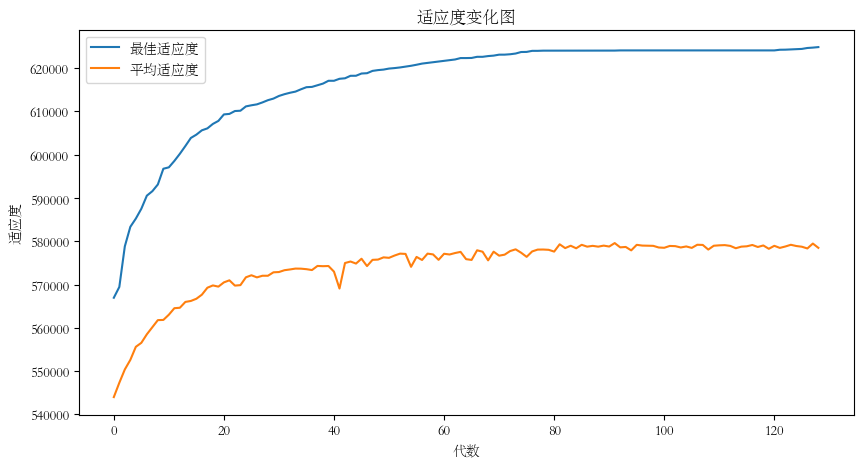

覆盖率：98.16%
已保存 311 个最佳候选点到文件 '../result/求阈值/最佳监测点_260_points.shp'
第 2 次运行...
Generation 0: Best Fitness = 569190.75
Generation 1: Best Fitness = 575168.5
Generation 2: Best Fitness = 577402.5625
Generation 3: Best Fitness = 578771.0
Generation 4: Best Fitness = 582529.5
Generation 5: Best Fitness = 585381.0
Generation 6: Best Fitness = 587719.25
Generation 7: Best Fitness = 590094.3125
Generation 8: Best Fitness = 593316.1875
Generation 9: Best Fitness = 594767.1875
Generation 10: Best Fitness = 595817.6875
Generation 11: Best Fitness = 596468.875
Generation 12: Best Fitness = 598752.6875
Generation 13: Best Fitness = 600325.5
Generation 14: Best Fitness = 601362.4375
Generation 15: Best Fitness = 601506.375
Generation 16: Best Fitness = 603435.375
Generation 17: Best Fitness = 603982.375
Generation 18: Best Fitness = 604586.875
Generation 19: Best Fitness = 605863.375
Generation 20: Best Fitness = 606422.125
Generation 21: Best Fitness = 607470.125
Generation 22: Best Fitness = 607617

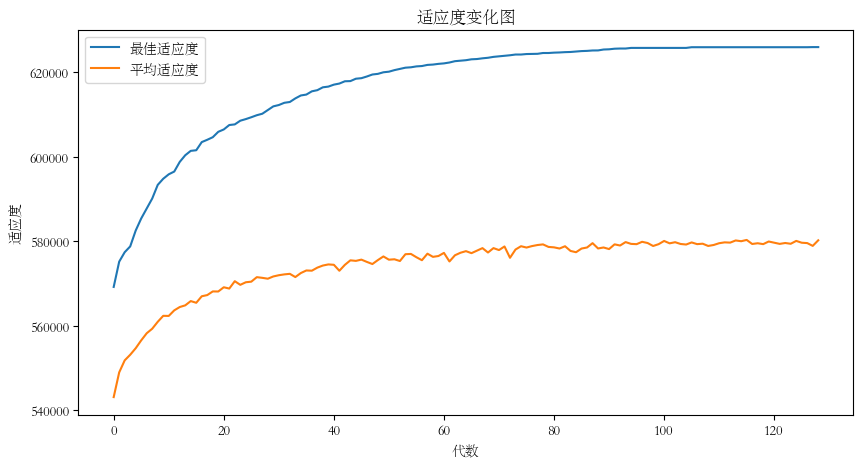

覆盖率：98.32%
已保存 311 个最佳候选点到文件 '../result/求阈值/最佳监测点_260_points.shp'
第 3 次运行...
Generation 0: Best Fitness = 568574.25
Generation 1: Best Fitness = 571980.0625
Generation 2: Best Fitness = 574057.6875
Generation 3: Best Fitness = 578677.9375
Generation 4: Best Fitness = 583447.8125
Generation 5: Best Fitness = 586818.625
Generation 6: Best Fitness = 587797.4375
Generation 7: Best Fitness = 591358.875
Generation 8: Best Fitness = 595940.5625
Generation 9: Best Fitness = 596858.6875
Generation 10: Best Fitness = 597261.625
Generation 11: Best Fitness = 598975.9375
Generation 12: Best Fitness = 600786.25
Generation 13: Best Fitness = 600786.25
Generation 14: Best Fitness = 602395.0625
Generation 15: Best Fitness = 602687.125
Generation 16: Best Fitness = 603894.5625
Generation 17: Best Fitness = 604240.375
Generation 18: Best Fitness = 605632.0625
Generation 19: Best Fitness = 606312.625
Generation 20: Best Fitness = 607155.4375
Generation 21: Best Fitness = 608361.875
Generation 22: Best Fi

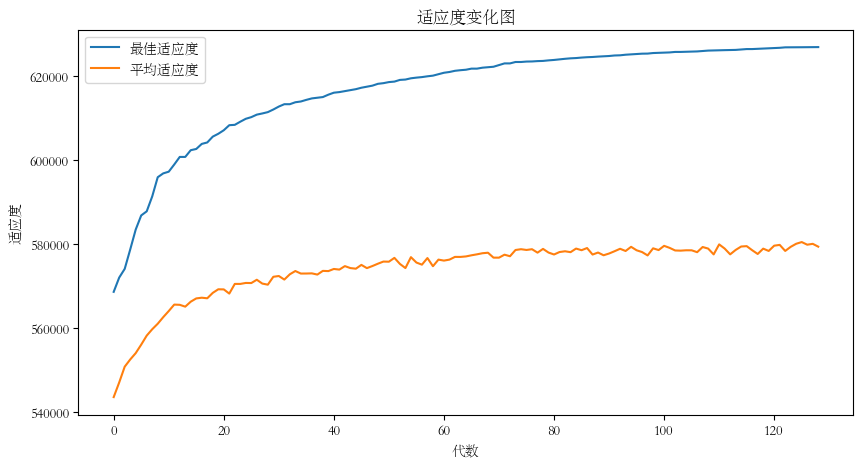

覆盖率：98.49%
已保存 311 个最佳候选点到文件 '../result/求阈值/最佳监测点_260_points.shp'
新增监测点数：260 - 最佳覆盖率：98.49%
运行遗传算法，新增监测点数量：280
调整后的最大迭代次数（对数增长）: 130
第 1 次运行...
Generation 0: Best Fitness = 580242.625
Generation 1: Best Fitness = 584351.75
Generation 2: Best Fitness = 589543.0
Generation 3: Best Fitness = 593212.3125
Generation 4: Best Fitness = 596434.875
Generation 5: Best Fitness = 598922.0625
Generation 6: Best Fitness = 600813.0625
Generation 7: Best Fitness = 602879.0
Generation 8: Best Fitness = 602879.0
Generation 9: Best Fitness = 605085.5625
Generation 10: Best Fitness = 606854.6875
Generation 11: Best Fitness = 608005.6875
Generation 12: Best Fitness = 609042.3125
Generation 13: Best Fitness = 609782.25
Generation 14: Best Fitness = 610751.1875
Generation 15: Best Fitness = 611565.0
Generation 16: Best Fitness = 612623.875
Generation 17: Best Fitness = 612500.375
Generation 18: Best Fitness = 613264.6875
Generation 19: Best Fitness = 614036.1875
Generation 20: Best Fitness = 614523.375
Gener

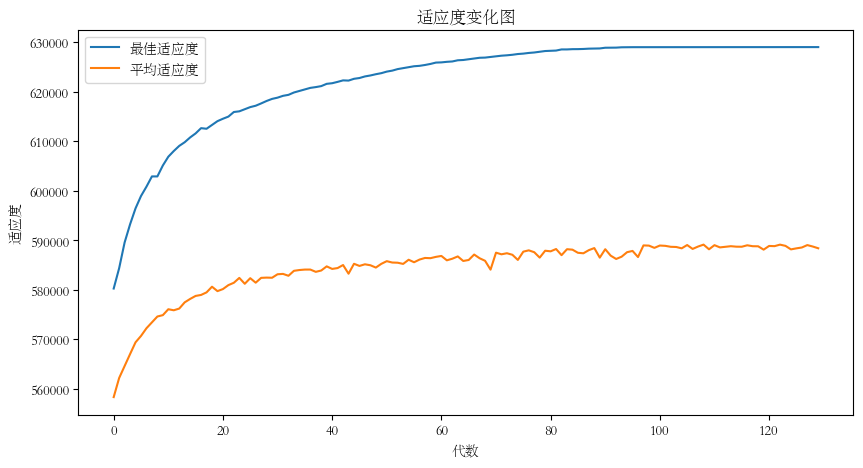

覆盖率：98.81%
已保存 331 个最佳候选点到文件 '../result/求阈值/最佳监测点_280_points.shp'
第 2 次运行...
Generation 0: Best Fitness = 580102.8125
Generation 1: Best Fitness = 587550.125
Generation 2: Best Fitness = 589848.5
Generation 3: Best Fitness = 593649.6875
Generation 4: Best Fitness = 593690.75
Generation 5: Best Fitness = 596318.5625
Generation 6: Best Fitness = 597601.625
Generation 7: Best Fitness = 599545.0625
Generation 8: Best Fitness = 600277.0625
Generation 9: Best Fitness = 601737.8125
Generation 10: Best Fitness = 603579.6875
Generation 11: Best Fitness = 603703.25
Generation 12: Best Fitness = 605688.6875
Generation 13: Best Fitness = 606012.75
Generation 14: Best Fitness = 608435.875
Generation 15: Best Fitness = 609563.25
Generation 16: Best Fitness = 609968.4375
Generation 17: Best Fitness = 611100.8125
Generation 18: Best Fitness = 612597.4375
Generation 19: Best Fitness = 613264.8125
Generation 20: Best Fitness = 613790.5625
Generation 21: Best Fitness = 614326.9375
Generation 22: Best Fit

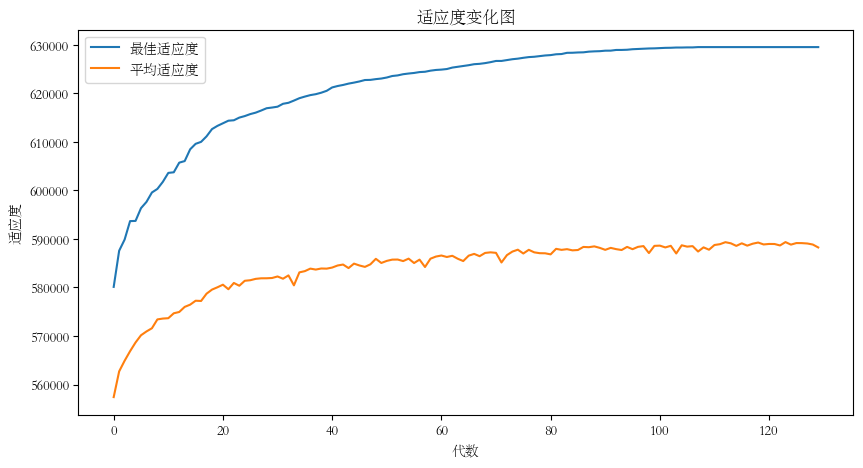

覆盖率：98.88%
已保存 331 个最佳候选点到文件 '../result/求阈值/最佳监测点_280_points.shp'
第 3 次运行...
Generation 0: Best Fitness = 581131.5
Generation 1: Best Fitness = 584967.5625
Generation 2: Best Fitness = 588724.875
Generation 3: Best Fitness = 592416.9375
Generation 4: Best Fitness = 594250.1875
Generation 5: Best Fitness = 597617.25
Generation 6: Best Fitness = 599867.875
Generation 7: Best Fitness = 601205.0
Generation 8: Best Fitness = 603924.875
Generation 9: Best Fitness = 606856.6875
Generation 10: Best Fitness = 607649.0
Generation 11: Best Fitness = 608193.6875
Generation 12: Best Fitness = 610162.6875
Generation 13: Best Fitness = 610955.125
Generation 14: Best Fitness = 611903.625
Generation 15: Best Fitness = 612448.25
Generation 16: Best Fitness = 613011.9375
Generation 17: Best Fitness = 613714.375
Generation 18: Best Fitness = 614110.4375
Generation 19: Best Fitness = 614645.75
Generation 20: Best Fitness = 615218.5625
Generation 21: Best Fitness = 615754.3125
Generation 22: Best Fitness = 

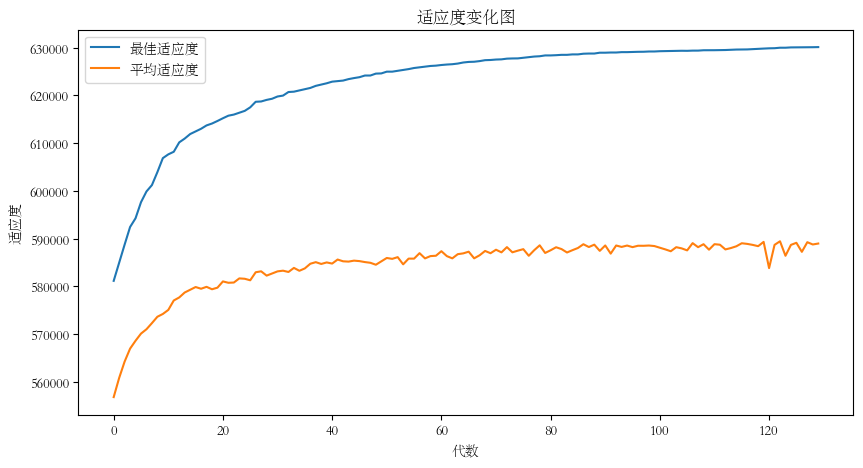

覆盖率：98.98%
已保存 331 个最佳候选点到文件 '../result/求阈值/最佳监测点_280_points.shp'
新增监测点数：280 - 最佳覆盖率：98.98%
运行遗传算法，新增监测点数量：300
调整后的最大迭代次数（对数增长）: 131
第 1 次运行...
Generation 0: Best Fitness = 592245.875
Generation 1: Best Fitness = 594254.4375
Generation 2: Best Fitness = 598112.875
Generation 3: Best Fitness = 602686.5
Generation 4: Best Fitness = 604008.875
Generation 5: Best Fitness = 606287.8125
Generation 6: Best Fitness = 608252.0
Generation 7: Best Fitness = 610900.9375
Generation 8: Best Fitness = 611125.4375
Generation 9: Best Fitness = 612359.5
Generation 10: Best Fitness = 613563.25
Generation 11: Best Fitness = 614424.3125
Generation 12: Best Fitness = 615441.5625
Generation 13: Best Fitness = 615821.0
Generation 14: Best Fitness = 616437.6875
Generation 15: Best Fitness = 617365.0
Generation 16: Best Fitness = 618084.1875
Generation 17: Best Fitness = 618751.5625
Generation 18: Best Fitness = 619132.625
Generation 19: Best Fitness = 619424.1875
Generation 20: Best Fitness = 620149.6875
Gener

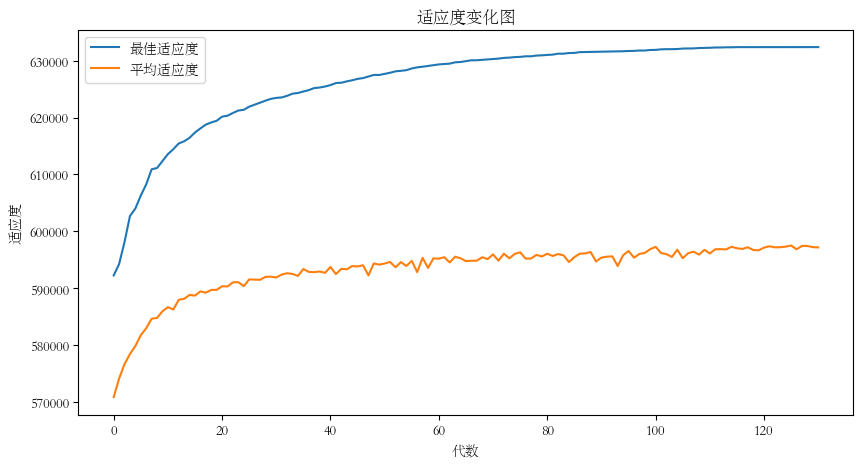

覆盖率：99.34%
已保存 351 个最佳候选点到文件 '../result/求阈值/最佳监测点_300_points.shp'
第 2 次运行...
Generation 0: Best Fitness = 589358.9375
Generation 1: Best Fitness = 594673.125
Generation 2: Best Fitness = 596718.1875
Generation 3: Best Fitness = 600018.9375
Generation 4: Best Fitness = 602522.5
Generation 5: Best Fitness = 604837.5
Generation 6: Best Fitness = 607885.1875
Generation 7: Best Fitness = 608610.4375
Generation 8: Best Fitness = 610563.375
Generation 9: Best Fitness = 611699.8125
Generation 10: Best Fitness = 612792.75
Generation 11: Best Fitness = 613347.875
Generation 12: Best Fitness = 614212.25
Generation 13: Best Fitness = 615336.5
Generation 14: Best Fitness = 615915.6875
Generation 15: Best Fitness = 616770.6875
Generation 16: Best Fitness = 617363.25
Generation 17: Best Fitness = 617771.5
Generation 18: Best Fitness = 619081.9375
Generation 19: Best Fitness = 619280.6875
Generation 20: Best Fitness = 619960.625
Generation 21: Best Fitness = 620081.125
Generation 22: Best Fitness = 62

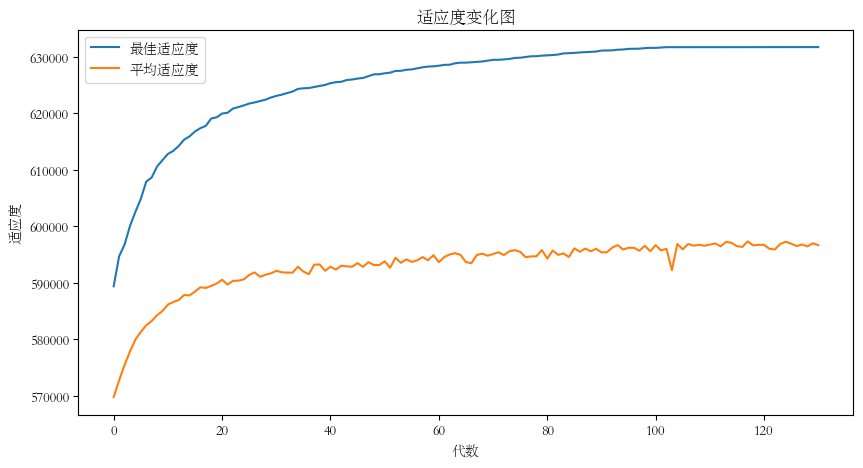

覆盖率：99.23%
已保存 351 个最佳候选点到文件 '../result/求阈值/最佳监测点_300_points.shp'
第 3 次运行...
Generation 0: Best Fitness = 590060.25
Generation 1: Best Fitness = 597470.0
Generation 2: Best Fitness = 599422.6875
Generation 3: Best Fitness = 601823.75
Generation 4: Best Fitness = 603304.3125
Generation 5: Best Fitness = 605076.1875
Generation 6: Best Fitness = 605947.625
Generation 7: Best Fitness = 608090.0625
Generation 8: Best Fitness = 610326.6875
Generation 9: Best Fitness = 610702.8125
Generation 10: Best Fitness = 612008.5625
Generation 11: Best Fitness = 612691.5625
Generation 12: Best Fitness = 614218.875
Generation 13: Best Fitness = 615745.6875
Generation 14: Best Fitness = 616346.0625
Generation 15: Best Fitness = 617637.5625
Generation 16: Best Fitness = 618659.375
Generation 17: Best Fitness = 619474.3125
Generation 18: Best Fitness = 620219.5625
Generation 19: Best Fitness = 620572.625
Generation 20: Best Fitness = 620873.6875
Generation 21: Best Fitness = 621157.625
Generation 22: Best F

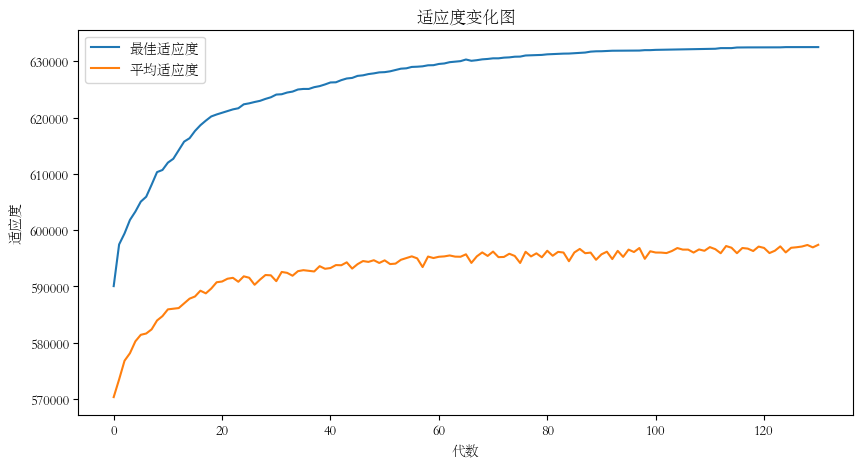

覆盖率：99.36%
已保存 351 个最佳候选点到文件 '../result/求阈值/最佳监测点_300_points.shp'
新增监测点数：300 - 最佳覆盖率：99.36%
运行遗传算法，新增监测点数量：320
调整后的最大迭代次数（对数增长）: 132
第 1 次运行...
Generation 0: Best Fitness = 597699.4375
Generation 1: Best Fitness = 602756.25
Generation 2: Best Fitness = 606342.4375
Generation 3: Best Fitness = 608555.25
Generation 4: Best Fitness = 609560.0625
Generation 5: Best Fitness = 611919.0625
Generation 6: Best Fitness = 614008.625
Generation 7: Best Fitness = 615900.0625
Generation 8: Best Fitness = 617298.3125
Generation 9: Best Fitness = 617298.3125
Generation 10: Best Fitness = 617950.375
Generation 11: Best Fitness = 618528.5625
Generation 12: Best Fitness = 619327.625
Generation 13: Best Fitness = 619914.8125
Generation 14: Best Fitness = 620498.875
Generation 15: Best Fitness = 620690.1875
Generation 16: Best Fitness = 621324.375
Generation 17: Best Fitness = 622118.9375
Generation 18: Best Fitness = 622388.4375
Generation 19: Best Fitness = 622870.5
Generation 20: Best Fitness = 624091.3

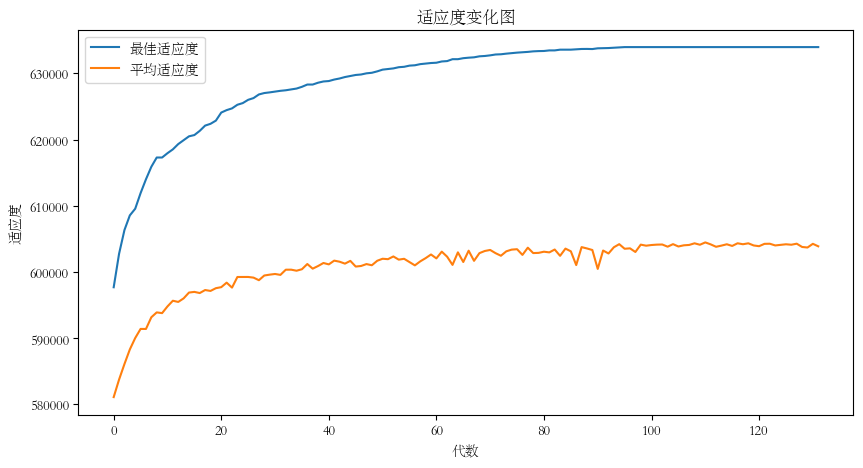

覆盖率：99.59%
已保存 371 个最佳候选点到文件 '../result/求阈值/最佳监测点_320_points.shp'
第 2 次运行...
Generation 0: Best Fitness = 599566.375
Generation 1: Best Fitness = 604207.375
Generation 2: Best Fitness = 608474.6875
Generation 3: Best Fitness = 611336.25
Generation 4: Best Fitness = 613434.875
Generation 5: Best Fitness = 613990.3125
Generation 6: Best Fitness = 615038.875
Generation 7: Best Fitness = 615895.75
Generation 8: Best Fitness = 616726.0
Generation 9: Best Fitness = 617709.8125
Generation 10: Best Fitness = 618649.0625
Generation 11: Best Fitness = 619358.25
Generation 12: Best Fitness = 620016.8125
Generation 13: Best Fitness = 620723.3125
Generation 14: Best Fitness = 621530.9375
Generation 15: Best Fitness = 622457.125
Generation 16: Best Fitness = 622647.8125
Generation 17: Best Fitness = 622904.625
Generation 18: Best Fitness = 623286.875
Generation 19: Best Fitness = 623936.9375
Generation 20: Best Fitness = 624178.5625
Generation 21: Best Fitness = 624450.625
Generation 22: Best Fitnes

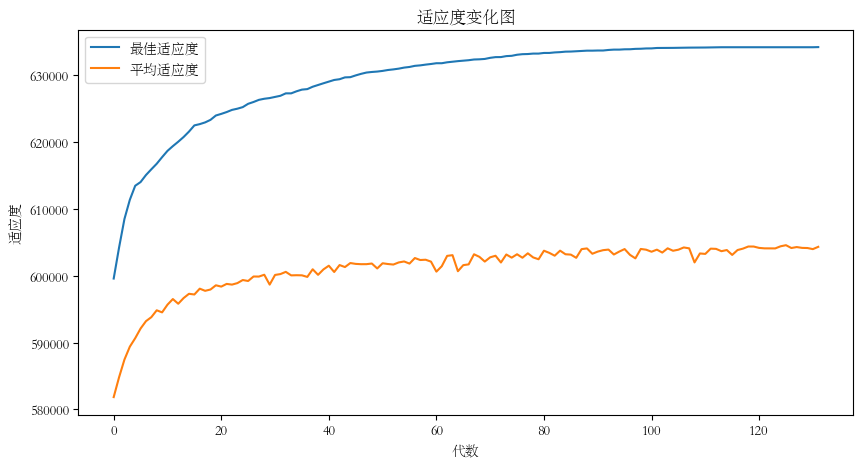

覆盖率：99.62%
已保存 371 个最佳候选点到文件 '../result/求阈值/最佳监测点_320_points.shp'
第 3 次运行...
Generation 0: Best Fitness = 597909.0625
Generation 1: Best Fitness = 603240.9375
Generation 2: Best Fitness = 607104.8125
Generation 3: Best Fitness = 610720.0625
Generation 4: Best Fitness = 612007.4375
Generation 5: Best Fitness = 614239.8125
Generation 6: Best Fitness = 615956.5
Generation 7: Best Fitness = 616484.75
Generation 8: Best Fitness = 617925.1875
Generation 9: Best Fitness = 619253.625
Generation 10: Best Fitness = 619711.3125
Generation 11: Best Fitness = 621082.3125
Generation 12: Best Fitness = 621790.3125
Generation 13: Best Fitness = 621983.5
Generation 14: Best Fitness = 622252.5625
Generation 15: Best Fitness = 622942.0
Generation 16: Best Fitness = 622956.25
Generation 17: Best Fitness = 623576.375
Generation 18: Best Fitness = 623881.375
Generation 19: Best Fitness = 624306.1875
Generation 20: Best Fitness = 624632.6875
Generation 21: Best Fitness = 624979.5625
Generation 22: Best Fitne

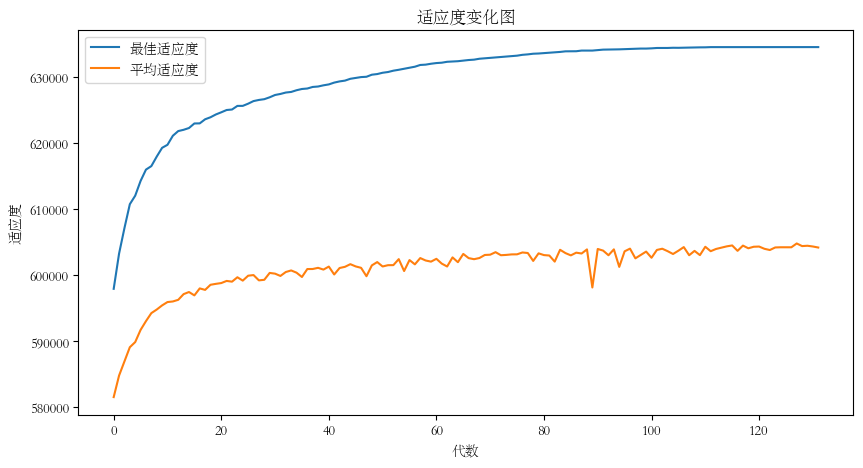

覆盖率：99.67%
已保存 371 个最佳候选点到文件 '../result/求阈值/最佳监测点_320_points.shp'
新增监测点数：320 - 最佳覆盖率：99.67%
运行遗传算法，新增监测点数量：340
调整后的最大迭代次数（对数增长）: 133
第 1 次运行...
Generation 0: Best Fitness = 608096.8125
Generation 1: Best Fitness = 612351.875
Generation 2: Best Fitness = 613594.6875
Generation 3: Best Fitness = 615202.3125
Generation 4: Best Fitness = 616779.8125
Generation 5: Best Fitness = 619197.375
Generation 6: Best Fitness = 619605.9375
Generation 7: Best Fitness = 621028.8125
Generation 8: Best Fitness = 622436.9375
Generation 9: Best Fitness = 623304.75
Generation 10: Best Fitness = 623925.8125
Generation 11: Best Fitness = 624512.5625
Generation 12: Best Fitness = 624811.9375
Generation 13: Best Fitness = 625421.75
Generation 14: Best Fitness = 625830.25
Generation 15: Best Fitness = 626346.9375
Generation 16: Best Fitness = 626840.8125
Generation 17: Best Fitness = 627464.1875
Generation 18: Best Fitness = 627820.3125
Generation 19: Best Fitness = 628203.6875
Generation 20: Best Fitness = 6288

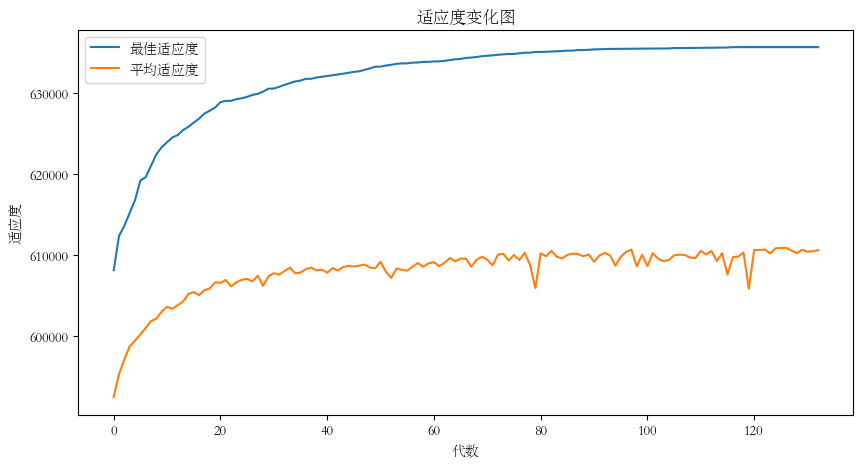

覆盖率：99.86%
已保存 391 个最佳候选点到文件 '../result/求阈值/最佳监测点_340_points.shp'
第 2 次运行...
Generation 0: Best Fitness = 605891.9375
Generation 1: Best Fitness = 610593.3125
Generation 2: Best Fitness = 613737.4375
Generation 3: Best Fitness = 615779.25
Generation 4: Best Fitness = 617726.9375
Generation 5: Best Fitness = 618374.75
Generation 6: Best Fitness = 619492.875
Generation 7: Best Fitness = 620758.625
Generation 8: Best Fitness = 621739.625
Generation 9: Best Fitness = 621977.0
Generation 10: Best Fitness = 622684.375
Generation 11: Best Fitness = 623624.625
Generation 12: Best Fitness = 623624.625
Generation 13: Best Fitness = 624208.75
Generation 14: Best Fitness = 624626.1875
Generation 15: Best Fitness = 625329.4375
Generation 16: Best Fitness = 625462.5625
Generation 17: Best Fitness = 625613.5625
Generation 18: Best Fitness = 625785.4375
Generation 19: Best Fitness = 625950.1875
Generation 20: Best Fitness = 626195.9375
Generation 21: Best Fitness = 626475.9375
Generation 22: Best Fitn

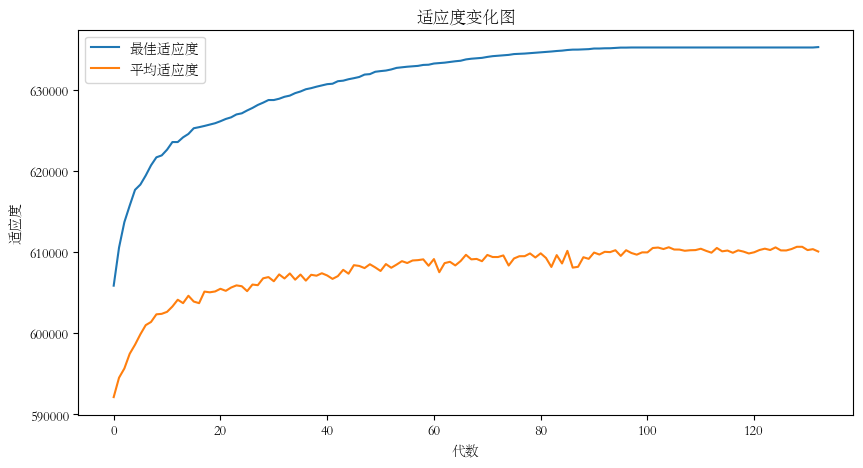

覆盖率：99.80%
已保存 391 个最佳候选点到文件 '../result/求阈值/最佳监测点_340_points.shp'
第 3 次运行...
Generation 0: Best Fitness = 607245.25
Generation 1: Best Fitness = 611490.6875
Generation 2: Best Fitness = 613042.8125
Generation 3: Best Fitness = 614818.1875
Generation 4: Best Fitness = 615821.5625
Generation 5: Best Fitness = 617168.8125
Generation 6: Best Fitness = 619560.5625
Generation 7: Best Fitness = 620424.0
Generation 8: Best Fitness = 621059.1875
Generation 9: Best Fitness = 621837.1875
Generation 10: Best Fitness = 622924.9375
Generation 11: Best Fitness = 623047.625
Generation 12: Best Fitness = 623933.375
Generation 13: Best Fitness = 624049.9375
Generation 14: Best Fitness = 624551.9375
Generation 15: Best Fitness = 625071.75
Generation 16: Best Fitness = 625474.375
Generation 17: Best Fitness = 626098.5625
Generation 18: Best Fitness = 626556.1875
Generation 19: Best Fitness = 626910.5625
Generation 20: Best Fitness = 627166.1875
Generation 21: Best Fitness = 627550.5
Generation 22: Best Fi

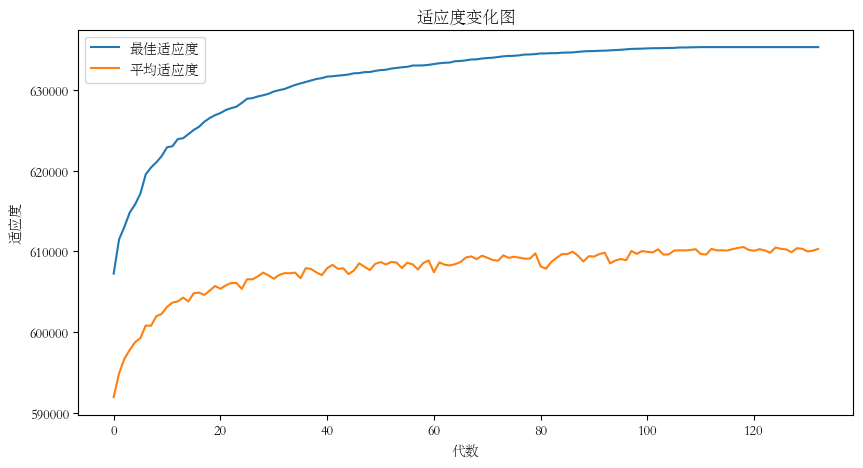

覆盖率：99.80%
已保存 391 个最佳候选点到文件 '../result/求阈值/最佳监测点_340_points.shp'
新增监测点数：340 - 最佳覆盖率：99.86%
运行遗传算法，新增监测点数量：360
调整后的最大迭代次数（对数增长）: 134
第 1 次运行...
Generation 0: Best Fitness = 614906.75
Generation 1: Best Fitness = 618700.5625
Generation 2: Best Fitness = 620536.25
Generation 3: Best Fitness = 621057.875
Generation 4: Best Fitness = 623827.75
Generation 5: Best Fitness = 624247.4375
Generation 6: Best Fitness = 625342.6875
Generation 7: Best Fitness = 625934.9375
Generation 8: Best Fitness = 626425.0625
Generation 9: Best Fitness = 626810.375
Generation 10: Best Fitness = 627020.375
Generation 11: Best Fitness = 627325.1875
Generation 12: Best Fitness = 627793.25
Generation 13: Best Fitness = 628127.5625
Generation 14: Best Fitness = 628205.8125
Generation 15: Best Fitness = 628497.5625
Generation 16: Best Fitness = 628821.1875
Generation 17: Best Fitness = 629201.5
Generation 18: Best Fitness = 629389.6875
Generation 19: Best Fitness = 629712.6875
Generation 20: Best Fitness = 629999.375

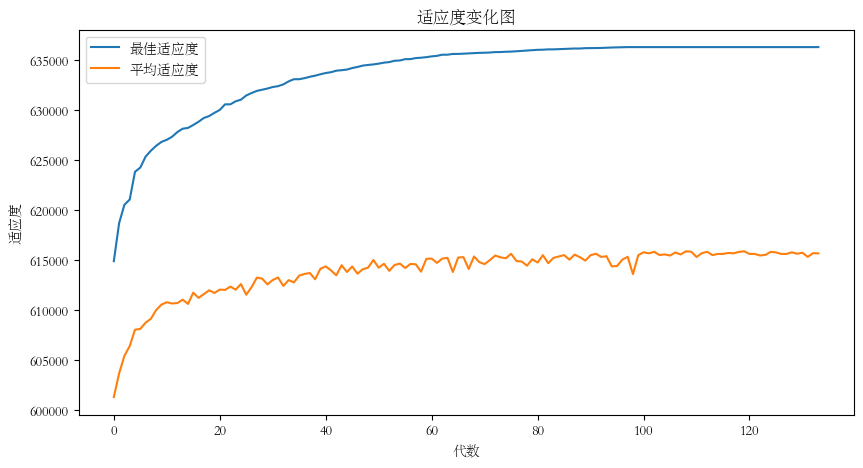

覆盖率：99.95%
已保存 411 个最佳候选点到文件 '../result/求阈值/最佳监测点_360_points.shp'
第 2 次运行...
Generation 0: Best Fitness = 614971.5625
Generation 1: Best Fitness = 616470.8125
Generation 2: Best Fitness = 619154.8125
Generation 3: Best Fitness = 621513.5
Generation 4: Best Fitness = 622389.875
Generation 5: Best Fitness = 623272.625
Generation 6: Best Fitness = 624316.0625
Generation 7: Best Fitness = 625028.0625
Generation 8: Best Fitness = 625672.625
Generation 9: Best Fitness = 625938.125
Generation 10: Best Fitness = 626729.1875
Generation 11: Best Fitness = 627151.8125
Generation 12: Best Fitness = 627774.375
Generation 13: Best Fitness = 628128.0
Generation 14: Best Fitness = 628320.1875
Generation 15: Best Fitness = 628502.6875
Generation 16: Best Fitness = 629077.3125
Generation 17: Best Fitness = 629135.25
Generation 18: Best Fitness = 629630.8125
Generation 19: Best Fitness = 629932.5625
Generation 20: Best Fitness = 630156.5625
Generation 21: Best Fitness = 630363.4375
Generation 22: Best Fi

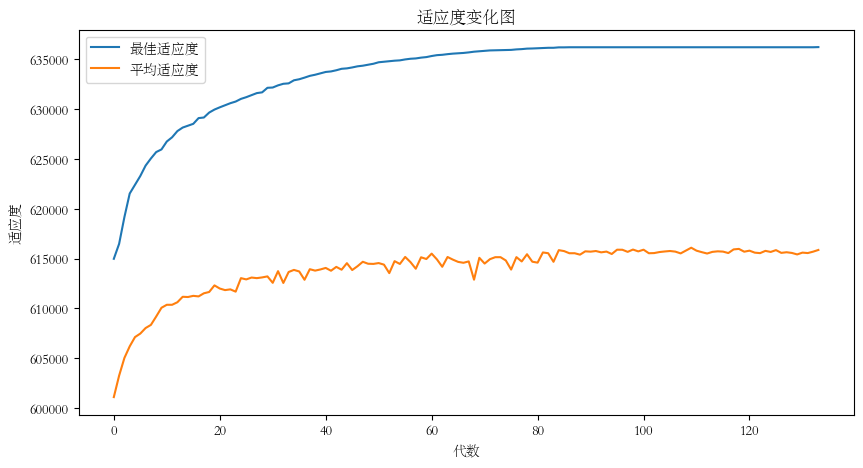

覆盖率：99.94%
已保存 411 个最佳候选点到文件 '../result/求阈值/最佳监测点_360_points.shp'
第 3 次运行...
Generation 0: Best Fitness = 613942.5625
Generation 1: Best Fitness = 618140.8125
Generation 2: Best Fitness = 618354.8125
Generation 3: Best Fitness = 619655.6875
Generation 4: Best Fitness = 620563.5625
Generation 5: Best Fitness = 621917.1875
Generation 6: Best Fitness = 623164.75
Generation 7: Best Fitness = 623617.4375
Generation 8: Best Fitness = 624767.1875
Generation 9: Best Fitness = 625541.3125
Generation 10: Best Fitness = 625901.4375
Generation 11: Best Fitness = 626661.8125
Generation 12: Best Fitness = 627157.5625
Generation 13: Best Fitness = 627653.875
Generation 14: Best Fitness = 628124.3125
Generation 15: Best Fitness = 628642.0625
Generation 16: Best Fitness = 629043.9375
Generation 17: Best Fitness = 629296.8125
Generation 18: Best Fitness = 629599.375
Generation 19: Best Fitness = 629865.4375
Generation 20: Best Fitness = 630117.6875
Generation 21: Best Fitness = 630582.3125
Generation 22

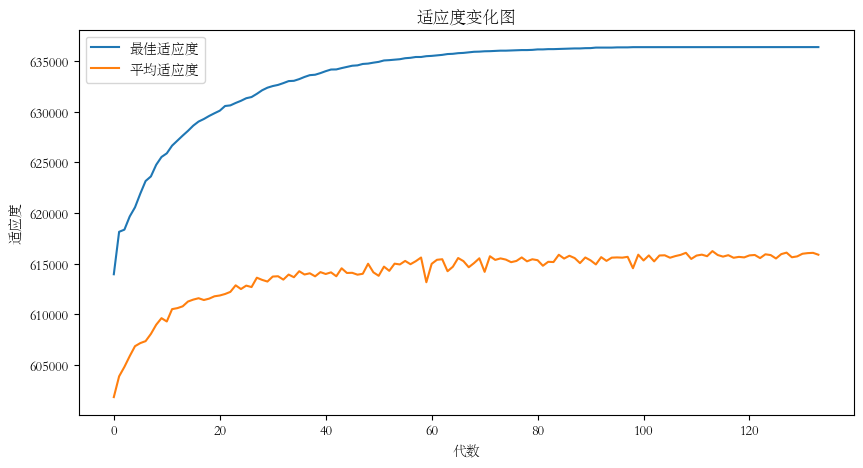

覆盖率：99.97%
已保存 411 个最佳候选点到文件 '../result/求阈值/最佳监测点_360_points.shp'
新增监测点数：360 - 最佳覆盖率：99.97%
运行遗传算法，新增监测点数量：380
调整后的最大迭代次数（对数增长）: 135
第 1 次运行...
Generation 0: Best Fitness = 620303.1875
Generation 1: Best Fitness = 622443.3125
Generation 2: Best Fitness = 623373.5
Generation 3: Best Fitness = 625079.0625
Generation 4: Best Fitness = 625812.6875
Generation 5: Best Fitness = 627033.1875
Generation 6: Best Fitness = 627736.3125
Generation 7: Best Fitness = 628190.625
Generation 8: Best Fitness = 629133.8125
Generation 9: Best Fitness = 629570.4375
Generation 10: Best Fitness = 629841.25
Generation 11: Best Fitness = 630159.1875
Generation 12: Best Fitness = 630675.875
Generation 13: Best Fitness = 631136.8125
Generation 14: Best Fitness = 631289.0625
Generation 15: Best Fitness = 631389.4375
Generation 16: Best Fitness = 631763.0625
Generation 17: Best Fitness = 632027.0
Generation 18: Best Fitness = 632418.9375
Generation 19: Best Fitness = 632557.9375
Generation 20: Best Fitness = 632760

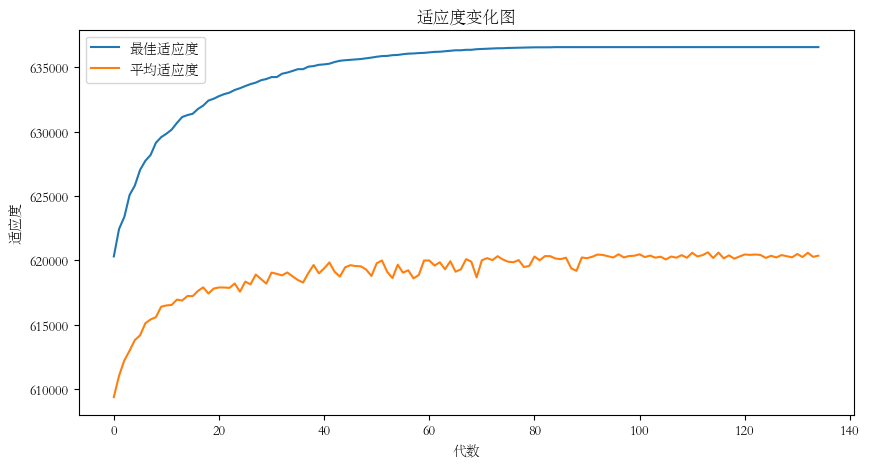

覆盖率：100.00%
已保存 431 个最佳候选点到文件 '../result/求阈值/最佳监测点_380_points.shp'
第 2 次运行...
Generation 0: Best Fitness = 621647.5
Generation 1: Best Fitness = 624391.9375
Generation 2: Best Fitness = 625094.125
Generation 3: Best Fitness = 625732.8125
Generation 4: Best Fitness = 626564.6875
Generation 5: Best Fitness = 627734.875
Generation 6: Best Fitness = 628147.6875
Generation 7: Best Fitness = 628693.8125
Generation 8: Best Fitness = 629077.9375
Generation 9: Best Fitness = 629512.125
Generation 10: Best Fitness = 629790.125
Generation 11: Best Fitness = 630091.4375
Generation 12: Best Fitness = 630484.375
Generation 13: Best Fitness = 630753.0625
Generation 14: Best Fitness = 631031.5
Generation 15: Best Fitness = 631360.375
Generation 16: Best Fitness = 631610.25
Generation 17: Best Fitness = 631915.8125
Generation 18: Best Fitness = 632173.0
Generation 19: Best Fitness = 632463.75
Generation 20: Best Fitness = 632659.25
Generation 21: Best Fitness = 632778.3125
Generation 22: Best Fitness =

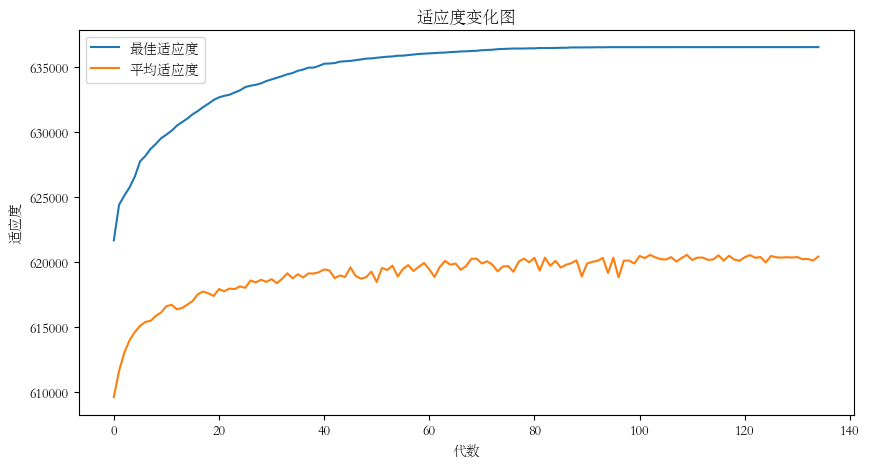

覆盖率：99.99%
已保存 431 个最佳候选点到文件 '../result/求阈值/最佳监测点_380_points.shp'
第 3 次运行...
Generation 0: Best Fitness = 618968.375
Generation 1: Best Fitness = 622094.6875
Generation 2: Best Fitness = 622081.3125
Generation 3: Best Fitness = 624086.25
Generation 4: Best Fitness = 625178.625
Generation 5: Best Fitness = 626520.5625
Generation 6: Best Fitness = 627710.0625
Generation 7: Best Fitness = 628482.5625
Generation 8: Best Fitness = 628745.9375
Generation 9: Best Fitness = 629169.3125
Generation 10: Best Fitness = 629453.0625
Generation 11: Best Fitness = 629798.875
Generation 12: Best Fitness = 630186.3125
Generation 13: Best Fitness = 630532.5625
Generation 14: Best Fitness = 631319.0625
Generation 15: Best Fitness = 631485.375
Generation 16: Best Fitness = 631636.3125
Generation 17: Best Fitness = 631796.5
Generation 18: Best Fitness = 632051.0
Generation 19: Best Fitness = 632435.875
Generation 20: Best Fitness = 632710.6875
Generation 21: Best Fitness = 633129.0
Generation 22: Best Fitne

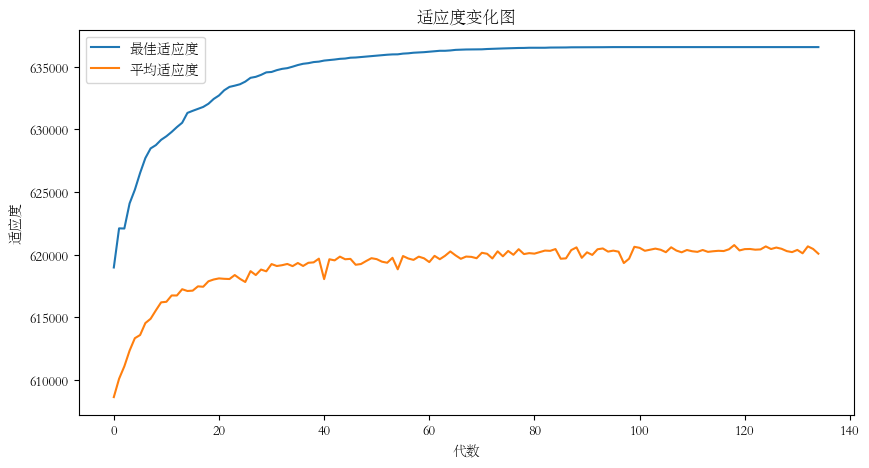

覆盖率：100.00%
已保存 431 个最佳候选点到文件 '../result/求阈值/最佳监测点_380_points.shp'
新增监测点数：380 - 最佳覆盖率：100.00%
覆盖率超过 90%，停止增加监测点数量。


,新增监测断面,总监测断面,人类活动强度增量,覆盖率
0,20,71,294678.56,46.29%
1,20,71,-1317.94,46.08%
2,20,71,-3184.81,45.58%
3,40,91,72419.59,56.96%
4,40,91,-441.53,56.89%
5,40,91,-4554.84,56.17%
6,60,111,62608.62,66.01%
7,60,111,-1313.31,65.80%
8,60,111,182.78,65.83%
9,80,131,48070.62,73.38%


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
# 初始化参数
pop_size = 50  # 种群大小
crossover_rate = 0.8  # 交叉概率
mutation_rate = 0.08  # 变异概率
base_generations = 50  # 基础迭代次数
runs_per_point_count = 3  # 每个监测点数量下的运行次数
increment = 20  # 每次增加的监测点数量
min_points = len(fixed_indices)  # 固定的保留点数量
initial_coverage = 0.3067  # 初始覆盖率为 30.6%
coverage_threshold = 0.9999  # 目标覆盖率
# 放缩系数 a 和对数底数 b 的设置
a = 10  # 调整增长速度
b = 2   # 对数底数
# 创建一个空的字典来保存不同监测点数量下的最佳覆盖率
coverage_results = {}
costs_results = []  # 用于保存每个方案的结果

# 假设 candidate_points_gdf 是包含候选点的 GeoDataFrame
num_candidates = len(candidate_points_gdf)  # 候选点的总数
coverage_results[0] = initial_coverage
# 从零新增监测点数量开始
num_points = 20
previous_total_cost = 0
previous_coverage = initial_coverage

while True:
    # 打印当前监测点数量
    print(f"运行遗传算法，新增监测点数量：{num_points}")
    
    best_coverages = []
    total_covered_intensity_values = []  # 用于保存每个方案的人类活动强度覆盖总量
    average_intensity_per_point_values = []  # 用于保存每个断面的平均覆盖强度

    # 根据监测点数量动态调整锦标赛选择的 K 值
    k = max(4, (num_points // 10) + 4)

    pop_size = 50 + (num_points // 10) * 10  # 根据监测点数量动态调整种群大小

    # 动态调整最大迭代次数（对数增长）
    adjusted_generations = base_generations + math.floor(a * math.log(num_points-10+ 1, b))
    print(f"调整后的最大迭代次数（对数增长）: {adjusted_generations}")

    for run_number in range(runs_per_point_count):
        print(f"第 {run_number + 1} 次运行...")

        # 初始化遗传算法
        ga = GeneticAlgorithm(
            pop_size=pop_size,
            num_candidates=num_candidates,
            crossover_rate=crossover_rate,
            mutation_rate=mutation_rate,
            max_generations=adjusted_generations,
            num_selected_points=min_points + num_points,  # 使用固定点和新增点总数
            fixed_indices=fixed_indices,
            k=k
        )

        # 运行遗传算法
        best_individual = ga.evolve(candidate_points_gdf, buffer_gdf, human_activity_raster)

        # 使用适应度作为覆盖的总强度
        total_covered_intensity = best_individual.fitness

        # 计算覆盖率
        coverage_ratio = total_covered_intensity / total_value
        best_coverages.append(coverage_ratio)
        print(f"覆盖率：{coverage_ratio:.2%}")
        
        # 计算每个方案的人类活动强度覆盖的增量
        incremented_covered_intensity = total_covered_intensity - previous_total_cost

        # 每个方案的增量数据保存
        new_points = num_points
        total_points = min_points + new_points  # 总断面数量

        # 保存每个方案的结果到列表中
        costs_results.append({
            '新增监测断面': new_points,
            '总监测断面': total_points,
            '人类活动强度增量': incremented_covered_intensity,
            '覆盖率': coverage_ratio
        })

        # 保存最佳个体的候选点
        save_best_individual_points(candidate_points_gdf, best_individual, num_points)

        # 更新上一个状态的成本和覆盖率
        previous_total_cost = total_covered_intensity
        previous_coverage = coverage_ratio

    # 找到最佳个体的覆盖率
    max_coverage = max(best_coverages)
    coverage_results[num_points] = max_coverage

    # 打印监测点数和对应覆盖率
    print(f"新增监测点数：{num_points} - 最佳覆盖率：{max_coverage:.2%}")

    # 检查是否覆盖率超过目标值
    if max_coverage >= coverage_threshold:
        print("覆盖率超过 90%，停止增加监测点数量。")
        break

    # 增加监测点数量
    num_points += increment

# 运行结束后，输出所有方案的结果
# 用于后续生成表格
df_results = pd.DataFrame(costs_results)

# 格式化输出
df_results['人类活动强度增量'] = df_results['人类活动强度增量'].apply(lambda x: f'{x:.2f}')
df_results['覆盖率'] = df_results['覆盖率'].apply(lambda x: f'{x * 100:.2f}%')  # 转换为百分比格式

import IPython.display as display
display.display(df_results)


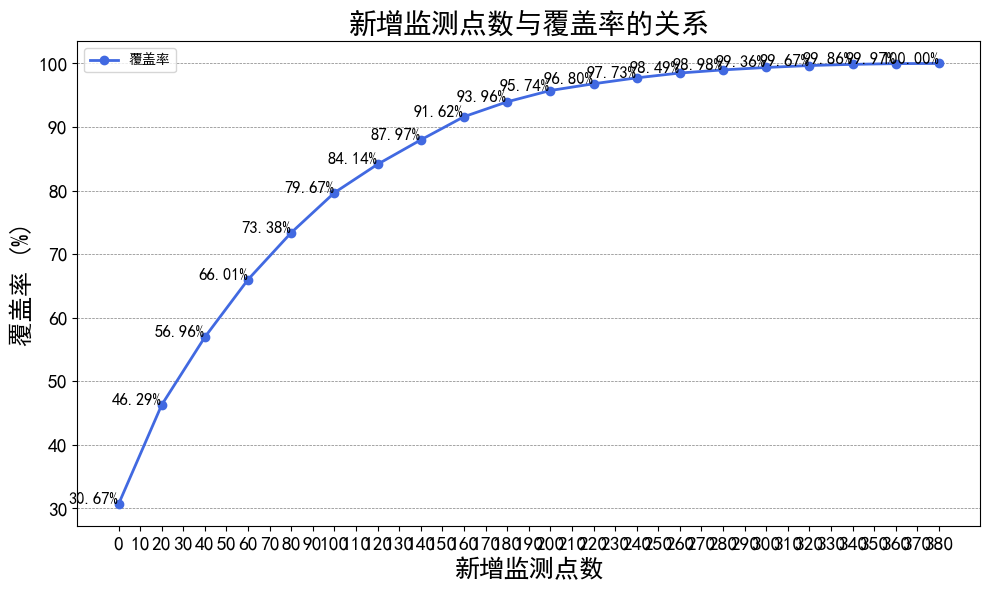

,新增监测断面,总监测断面,人类活动强度增量,覆盖率
0,20,71,294678.56,46.29%
1,20,71,-1317.94,46.08%
2,20,71,-3184.81,45.58%
3,40,91,72419.59,56.96%
4,40,91,-441.53,56.89%
5,40,91,-4554.84,56.17%
6,60,111,62608.62,66.01%
7,60,111,-1313.31,65.80%
8,60,111,182.78,65.83%
9,80,131,48070.62,73.38%


In [17]:
import matplotlib.pyplot as plt
import pandas as pd


# 绘制覆盖率与新增监测点数的关系图
x_values = list(coverage_results.keys())  # 新增监测点数
y_values = [coverage_results[x] * 100 for x in x_values]  # 覆盖率，转换为百分比

plt.figure(figsize=(10, 6))  # 调整图表大小
plt.plot(x_values, y_values, marker='o', color='royalblue', linestyle='-', linewidth=2, markersize=6)

# 设置横坐标的间隔为10
plt.xticks(range(min(x_values), max(x_values) + 1, 10), fontsize=14, fontname='SimHei')  # 横坐标间隔为10并加大字体
plt.yticks(fontsize=14, fontname='SimHei')  # 纵坐标加大字体

# 添加坐标轴标签和标题，并设置为黑体加粗和更大的字体大小
plt.xlabel('新增监测点数', fontsize=18, fontweight='bold', fontname='SimHei')
plt.ylabel('覆盖率 (%)', fontsize=18, fontweight='bold', fontname='SimHei')
plt.title('新增监测点数与覆盖率的关系', fontsize=20, fontweight='bold', fontname='SimHei')

# 显示每个点的覆盖率，覆盖率数值带有百分号
for i, txt in enumerate(y_values):
    plt.text(x_values[i], y_values[i], f'{txt:.2f}%', ha='right', fontsize=12, color='black', fontweight='bold', fontname='SimHei')

plt.legend(['覆盖率'], loc='best', fontsize=14, prop={'weight': 'bold', 'family': 'SimHei'})

# 设置背景颜色为白色，并只保留横向网格线
plt.grid(True, axis='y', color='gray', linestyle='--', linewidth=0.5)  # 仅显示横向网格线
plt.gca().set_facecolor('white')  # 设置背景颜色为白色
plt.tight_layout()  # 自动调整子图参数，使之填充整个图像区域
plt.show()

# 将成本结果转换为 DataFrame 并展示为表格
df_results = pd.DataFrame(costs_results)

# 格式化表格
df_results['覆盖率'] = df_results['覆盖率'].apply(lambda x: f'{x * 100:.2f}%')  # 转换覆盖率为百分比
df_results['人类活动强度增量'] = df_results['人类活动强度增量'].apply(lambda x: f'{x:.2f}')  # 保留两位小数
df_results['总监测断面'] = df_results['总监测断面'].apply(lambda x: f'{x}')  # 显示总断面数
df_results['新增监测断面'] = df_results['新增监测断面'].apply(lambda x: f'{x}')  # 显示新增监测断面数

# 显示格式化后的表格
import IPython.display as display
display.display(df_results)


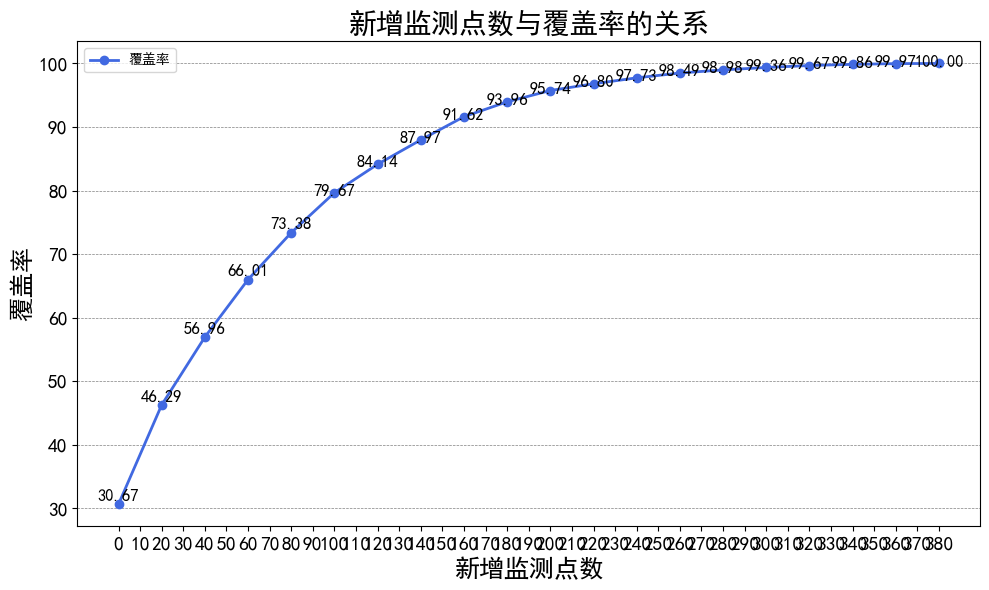

,新增监测断面,总监测断面,人类活动强度增量,覆盖率
0,20,71,294678.56,46.29
1,20,71,-1317.94,46.08
2,20,71,-3184.81,45.58
3,40,91,72419.59,56.96
4,40,91,-441.53,56.89
5,40,91,-4554.84,56.17
6,60,111,62608.62,66.01
7,60,111,-1313.31,65.80
8,60,111,182.78,65.83
9,80,131,48070.62,73.38


In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# 绘制覆盖率与新增监测点数的关系图
x_values = list(coverage_results.keys())  # 新增监测点数
y_values = [coverage_results[x] * 100 for x in x_values]  # 覆盖率，转换为百分比

plt.figure(figsize=(10, 6))  # 调整图表大小
plt.plot(x_values, y_values, marker='o', color='royalblue', linestyle='-', linewidth=2, markersize=6)

# 设置横坐标的间隔为10
plt.xticks(range(min(x_values), max(x_values) + 1, 10), fontsize=14, fontname='SimHei')  # 横坐标间隔为10并加大字体
plt.yticks(fontsize=14, fontname='SimHei')  # 纵坐标加大字体

# 添加坐标轴标签和标题，并设置为黑体加粗和更大的字体大小
plt.xlabel('新增监测点数', fontsize=18, fontweight='bold', fontname='SimHei')
plt.ylabel('覆盖率', fontsize=18, fontweight='bold', fontname='SimHei')
plt.title('新增监测点数与覆盖率的关系', fontsize=20, fontweight='bold', fontname='SimHei')

# 调整每个点的标注逻辑
for i, txt in enumerate(y_values):
    if x_values[i] <= 90:
        plt.text(x_values[i], y_values[i] + 0.5, f'{txt:.2f}', ha='center', fontsize=12, color='black', fontweight='bold', fontname='SimHei')  # 标注在上方
    else:
        plt.text(x_values[i], y_values[i] - 0.5, f'{txt:.2f}', ha='center', fontsize=12, color='black', fontweight='bold', fontname='SimHei')  # 标注在下方

plt.legend(['覆盖率'], loc='best', fontsize=14, prop={'weight': 'bold', 'family': 'SimHei'})

# 设置背景颜色为白色，并只保留横向网格线
plt.grid(True, axis='y', color='gray', linestyle='--', linewidth=0.5)  # 仅显示横向网格线
plt.gca().set_facecolor('white')  # 设置背景颜色为白色
plt.tight_layout()  # 自动调整子图参数，使之填充整个图像区域
plt.show()

# 将成本结果转换为 DataFrame 并展示为表格
df_results = pd.DataFrame(costs_results)

# 格式化表格
df_results['覆盖率'] = df_results['覆盖率'].apply(lambda x: f'{x * 100:.2f}')  # 转换覆盖率为百分比，但不显示 % 号
df_results['人类活动强度增量'] = df_results['人类活动强度增量'].apply(lambda x: f'{x:.2f}')  # 保留两位小数
df_results['总监测断面'] = df_results['总监测断面'].apply(lambda x: f'{x}')  # 显示总断面数
df_results['新增监测断面'] = df_results['新增监测断面'].apply(lambda x: f'{x}')  # 显示新增监测断面数

# 显示格式化后的表格
import IPython.display as display
display.display(df_results)


In [22]:
# 打印 coverage_results 的内容
for key, value in coverage_results.items():
    print(f"新增监测点数: {key}, 覆盖率: {value * 100:.2f}%")


新增监测点数: 0, 覆盖率: 30.67%
新增监测点数: 20, 覆盖率: 46.29%
新增监测点数: 40, 覆盖率: 56.96%
新增监测点数: 60, 覆盖率: 66.01%
新增监测点数: 80, 覆盖率: 73.38%
新增监测点数: 100, 覆盖率: 79.67%
新增监测点数: 120, 覆盖率: 84.14%
新增监测点数: 140, 覆盖率: 87.97%
新增监测点数: 160, 覆盖率: 91.62%
新增监测点数: 180, 覆盖率: 93.96%
新增监测点数: 200, 覆盖率: 95.74%
新增监测点数: 220, 覆盖率: 96.80%
新增监测点数: 240, 覆盖率: 97.73%
新增监测点数: 260, 覆盖率: 98.49%
新增监测点数: 280, 覆盖率: 98.98%
新增监测点数: 300, 覆盖率: 99.36%
新增监测点数: 320, 覆盖率: 99.67%
新增监测点数: 340, 覆盖率: 99.86%
新增监测点数: 360, 覆盖率: 99.97%
新增监测点数: 380, 覆盖率: 100.00%


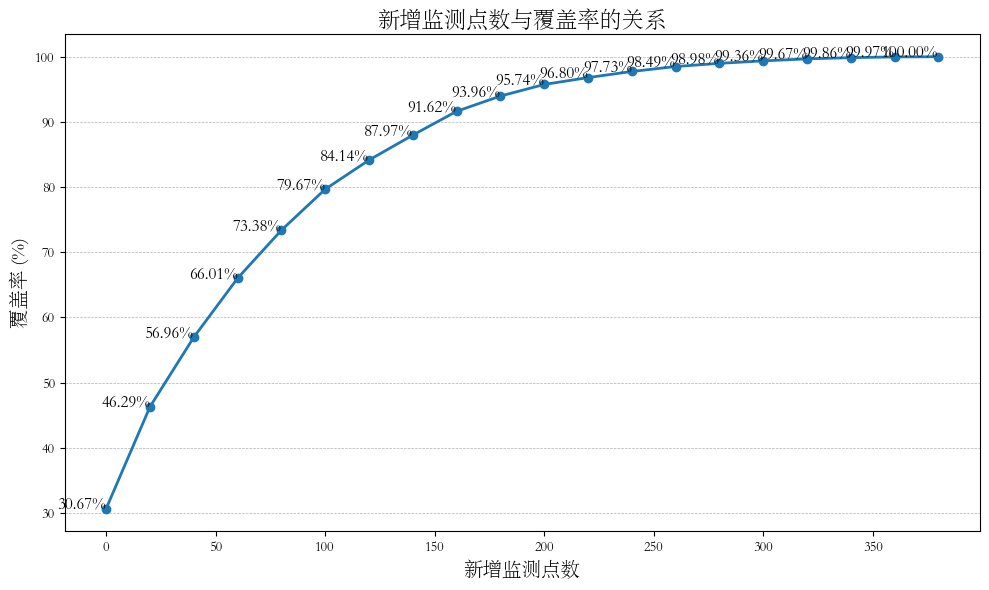

In [23]:
import matplotlib.pyplot as plt

# 提取数据
x_values = list(coverage_results.keys())  # 新增监测点数
y_values = [value * 100 for value in coverage_results.values()]  # 覆盖率，转换为百分比

# 绘制图形
plt.figure(figsize=(10, 6))  # 设置图形大小
plt.plot(x_values, y_values, marker='o', linestyle='-', linewidth=2, markersize=6)

# 添加标题和坐标轴标签
plt.title("新增监测点数与覆盖率的关系", fontsize=16, fontweight='bold')
plt.xlabel("新增监测点数", fontsize=14)
plt.ylabel("覆盖率 (%)", fontsize=14)

# 显示覆盖率值
for x, y in zip(x_values, y_values):
    plt.text(x, y, f"{y:.2f}%", fontsize=12, ha='right')

# 显示网格线
plt.grid(axis='y', linestyle='--', linewidth=0.5)

# 显示图形
plt.tight_layout()
plt.show()


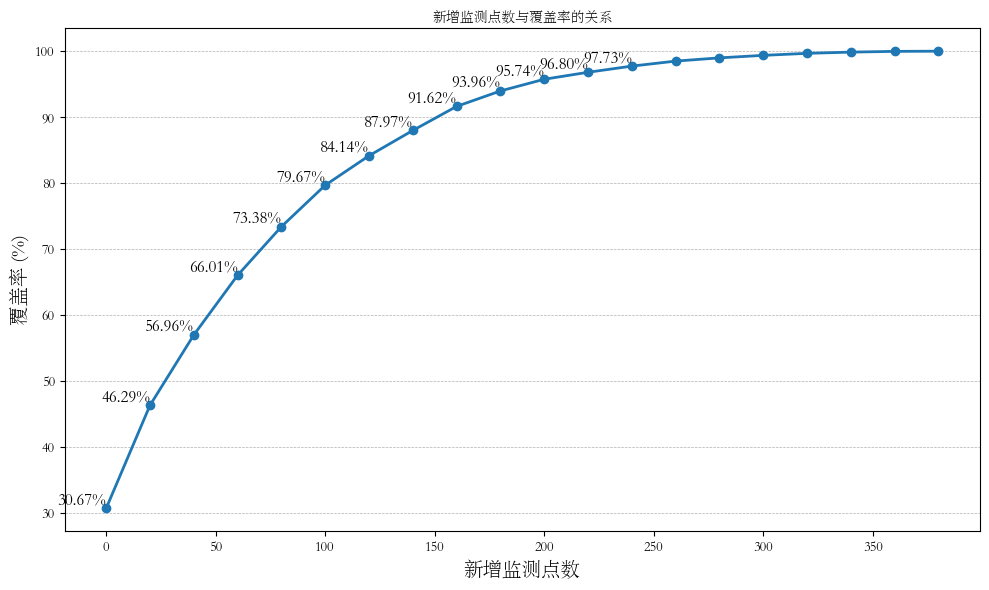

In [31]:
import matplotlib.pyplot as plt

# 提取数据
x_values = list(coverage_results.keys())  # 新增监测点数
y_values = [value * 100 for value in coverage_results.values()]  # 覆盖率，转换为百分比

# 绘制图形
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, marker='o', linestyle='-', linewidth=2, markersize=6)

# 添加标题和坐标轴标签
plt.title("新增监测点数与覆盖率的关系", fontsize=10, fontweight='bold')
plt.xlabel("新增监测点数", fontsize=14)
plt.ylabel("覆盖率 (%)", fontsize=14)

# 仅标注特定点，限制标注到250个新增监测点之前
for x, y in zip(x_values, y_values):
    if x <= 250:  # 限制标注点
        plt.text(x, y, f"{y:.2f}%", fontsize=12, ha='right', va='bottom')

# 显示网格线
plt.grid(axis='y', linestyle='--', linewidth=0.5)

# 显示图形
plt.tight_layout()
plt.show()


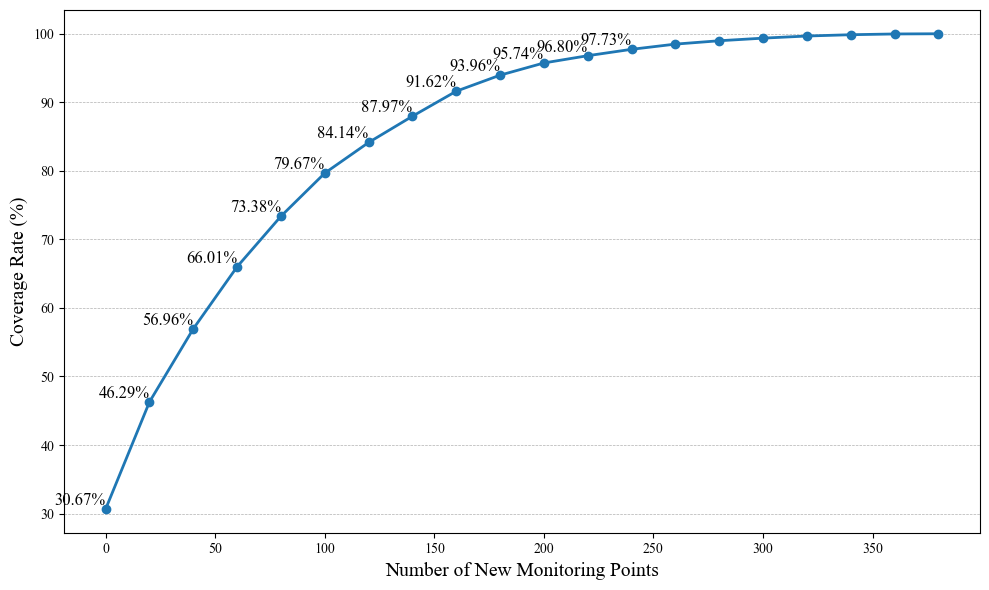

In [1]:
import matplotlib.pyplot as plt

# 设置字体为 Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.unicode_minus'] = False  # 负号显示正常

# 覆盖率数据
coverage_results = {
    0: 0.3067, 20: 0.4629, 40: 0.5696, 60: 0.6601, 80: 0.7338, 100: 0.7967,
    120: 0.8414, 140: 0.8797, 160: 0.9162, 180: 0.9396, 200: 0.9574,
    220: 0.9680, 240: 0.9773, 260: 0.9849, 280: 0.9898, 300: 0.9936,
    320: 0.9967, 340: 0.9986, 360: 0.9997, 380: 1.0
}

# 提取 x 和 y 数据
x_values = list(coverage_results.keys())
y_values = [value * 100 for value in coverage_results.values()]  # 转换为百分比

# 创建图形
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, marker='o', linestyle='-', linewidth=2, markersize=6)

# 设置标题和坐标轴
plt.title("",
          fontsize=12, fontweight='bold')
plt.xlabel("Number of New Monitoring Points", fontsize=14)
plt.ylabel("Coverage Rate (%)", fontsize=14)

# 标注前250个新增点以内的数据点
for x, y in zip(x_values, y_values):
    if x <= 250:
        plt.text(x, y, f"{y:.2f}%", fontsize=12, ha='right', va='bottom')

# 添加网格线
plt.grid(axis='y', linestyle='--', linewidth=0.5)

# 自动调整子图参数，使之填充整个图像区域
plt.tight_layout()

# 保存为 PDF 文件
plt.savefig("coverage_rate_plot_with_chinese.pdf", format="pdf")
plt.show()
